In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import linregress

# Preparing plot with variable font sizes
TITLE_FONTSIZE = 24
LEGEND_FONTSIZE = 16
AXIS_TICK_FONTSIZE = 18
AXIS_LABEL_FONTSIZE = AXIS_TICK_FONTSIZE + 6
FONT_WEIGHT = "normal"
DPI = 300

RESULT_PATH = Path("../assets/result/new")
FIGURE_PATH =  Path("../assets/result/figure")

In [2]:
COLOR = {
    "blue": "#004e94",
    "orange": "#d55b00",
    "yellow": "#ffbd00",
    "purple": "#7e2289",
    "green": "#007e6a",
    "red": "#c80723",
    "1": "#82B1D3",
    "2": "#E0B48C",
}

# Result Figure 1

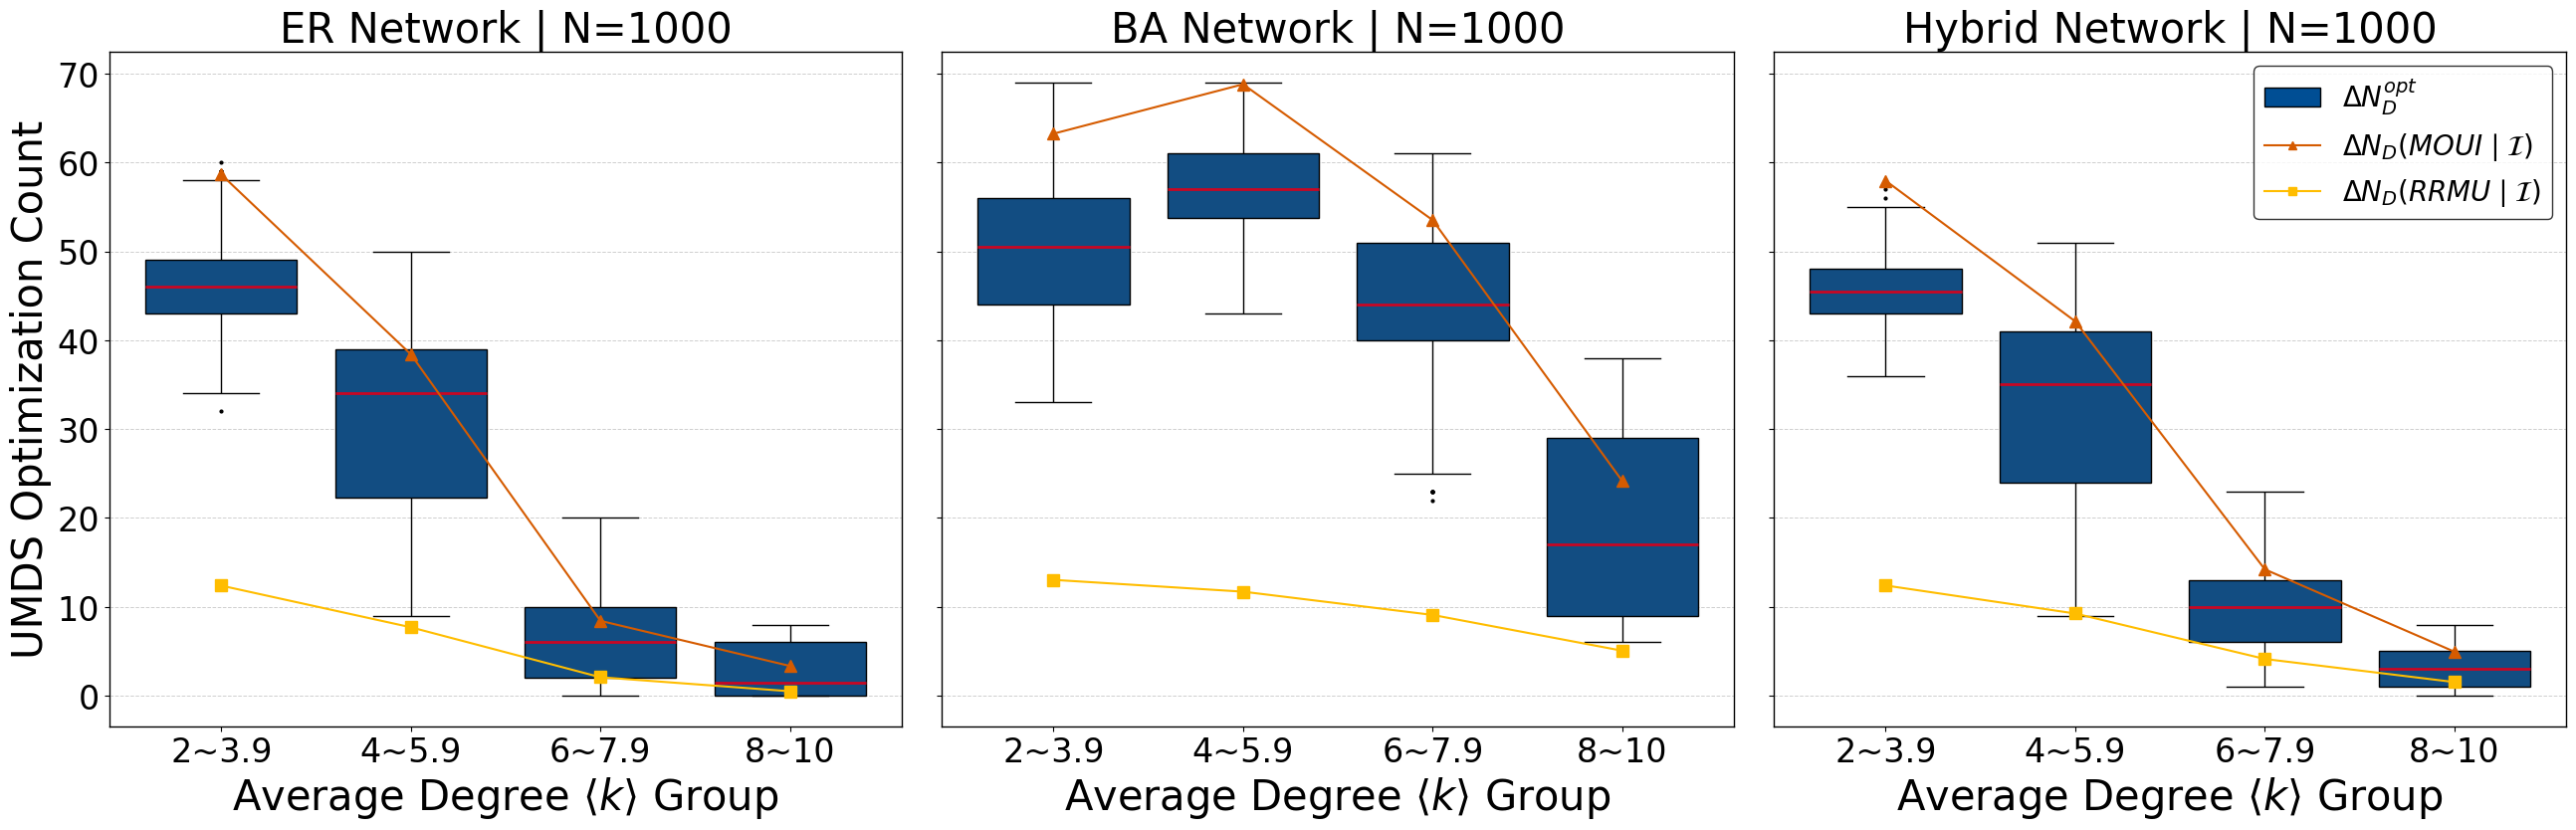

In [ ]:
df = pd.read_csv(RESULT_PATH / "optimization_amount.csv")

# Network type mapping
network_type_mapping = {
    "ER+ER": "ER",
    "BA+BA": "BA",
    "ER+BA": "Hybrid" # Changed from "Hybird" to "Hybrid"
}
df['network_type_display'] = df['network_type'].map(network_type_mapping)

# Calculate optimization metric
df['Opt_vs_Baseline'] = df['UMDS_1'] - df['UMDS_2']
df['Opt_MOUI'] = df['UMDS_0'] - df['UMDS_2']
df['Opt_RRMU'] = df['UMDS_0'] - df['UMDS_1']

# Define <k> bins/groups
# Correcting k_labels generation for the last bin
k_edges = [2, 4, 6, 8, 10.1]
k_labels = [f'{k_edges[i]}~{k_edges[i+1]-0.1 if i < len(k_edges)-2 else k_edges[i+1]}' for i in range(len(k_edges)-1)]
k_labels[-1] = f'{k_edges[-2]}~{int(k_edges[-1]-0.1)}'


# Ensure k_labels has the correct number of elements if k_edges leads to an edge case
if len(k_labels) != len(k_edges) -1:
     k_labels = [f'{k_edges[i]}~{k_edges[i+1]-0.1}' for i in range(len(k_edges)-1)] # Fallback or adjust as needed


df['k_group'] = pd.cut(df['<k>'], bins=k_edges, labels=k_labels, right=False, include_lowest=True)


# --- Plot 1: Optimization vs Baseline ---

# Define a color for the boxes to ensure consistency.
box_color = COLOR['blue']
median_color = COLOR['red']

# Create the base catplot with boxplots
g_opt = sns.catplot(
    data=df,
    x='k_group',
    y='Opt_vs_Baseline',
    row='N',
    col='network_type_display', # Use the display name for column titles
    order=k_labels, # Ensure x-axis order is correct
    col_order=network_type_mapping.values(), # Ensure column order if needed
    kind='box',
    height=8.8, aspect=1.1,
    sharey='row',
    legend=False, # We will create a custom legend later
    color=box_color, # Set a uniform color for all boxes
    medianprops={'color': median_color, 'linewidth': 2}, # Make medians stand out
    boxprops={'edgecolor': 'black', 'linewidth': 1},
    whiskerprops={'color': 'black', 'linewidth': 1},
    capprops={'color': 'black', 'linewidth': 1},
    flierprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 2} # Style outliers
)

# --- Add Line Plots and Custom Legend ---

# Aggregate data for the line plots
line_data = df.groupby(['N', 'network_type_display', 'k_group'], observed=True)[['Opt_MOUI', 'Opt_RRMU']].mean().reset_index()

# Define styles for the line plots for clarity and consistency
line_styles = {
    'Opt_MOUI': {'color': COLOR['orange'], 'marker': '^', 'label': r'$\Delta N_D(MOUI \mid \mathcal{I})$'},
    'Opt_RRMU': {'color': COLOR['yellow'], 'marker': 's', 'label': r'$\Delta N_D(RRMU \mid \mathcal{I})$'}
}

# Iterate over the subplots to overlay the line plots
for i, n_val in enumerate(g_opt.row_names):
    for j, net_type in enumerate(g_opt.col_names):
        ax = g_opt.axes[i, j]
        subplot_line_data = line_data[(line_data['N'] == n_val) & (line_data['network_type_display'] == net_type)].copy()
        
        if not subplot_line_data.empty:
            subplot_line_data['k_group'] = pd.Categorical(subplot_line_data['k_group'], categories=k_labels, ordered=True)
            subplot_line_data = subplot_line_data.sort_values('k_group')
            x_coords = subplot_line_data['k_group'].cat.codes
            
            # By setting a high zorder, we ensure the line plots are drawn on top of the boxplot elements.
            ax.plot(x_coords, subplot_line_data['Opt_MOUI'], color=line_styles['Opt_MOUI']['color'], marker=line_styles['Opt_MOUI']['marker'], linestyle='-', linewidth=1.5, markersize=8, zorder=10)
            ax.plot(x_coords, subplot_line_data['Opt_RRMU'], color=line_styles['Opt_RRMU']['color'], marker=line_styles['Opt_RRMU']['marker'], linestyle='-', linewidth=1.5, markersize=8, zorder=5)

# Create a custom legend for the entire figure
legend_handles = [
    Patch(facecolor=box_color, edgecolor='black', label=r'$\Delta N_{D}^{opt}$'),
    Line2D([0], [0], color=line_styles['Opt_MOUI']['color'], marker=line_styles['Opt_MOUI']['marker'], linestyle='-', label=line_styles['Opt_MOUI']['label']),
    Line2D([0], [0], color=line_styles['Opt_RRMU']['color'], marker=line_styles['Opt_RRMU']['marker'], linestyle='-', label=line_styles['Opt_RRMU']['label'])
]

# Get the axes for the top-right subplot (first row, last column)
ax_legend = g_opt.axes[0, -1]
# Add the legend to this specific subplot
leg = ax_legend.legend(handles=legend_handles, loc='upper right', frameon=True, edgecolor='black', fontsize=LEGEND_FONTSIZE + 6 - 2)
for text in leg.get_texts():
    text.set_fontweight(FONT_WEIGHT)

# --- Customize Plot Appearance ---
g_opt.set_axis_labels(r"Average Degree $\langle k \rangle$ Group", "UMDS Optimization Count", fontsize=AXIS_LABEL_FONTSIZE + 6, fontweight=FONT_WEIGHT)
g_opt.set_titles(r"{col_name} Network | N={row_name}")

for i, ax_row in enumerate(g_opt.axes):
    for j, ax in enumerate(ax_row):
        ax.set_title(ax.get_title(), fontsize=TITLE_FONTSIZE + 6, fontweight=FONT_WEIGHT)
        ax.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE + 6)
        ax.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE + 6)
        for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
            ticklabel.set_fontweight(FONT_WEIGHT)
        ax.grid(True, axis='y', linestyle='--', alpha=0.6, linewidth=0.7)
        
        if j == 0:
            ax.set_ylabel(ax.get_ylabel(), fontsize=AXIS_LABEL_FONTSIZE + 6, fontweight=FONT_WEIGHT)
        else:
            ax.set_ylabel("")
        
        if i == len(g_opt.axes) - 1:
             ax.set_xlabel(ax.get_xlabel(), fontsize=AXIS_LABEL_FONTSIZE + 6, fontweight=FONT_WEIGHT)
        else:
            ax.set_xlabel("")

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1)

# Adjust layout (top margin can be smaller now)
g_opt.figure.subplots_adjust(top=0.92, bottom=0.15, left=0.1, right=0.95, hspace=0.2, wspace=0.05)

figure_save_path_opt = FIGURE_PATH / "fig.1.optimization_vs_baseline_boxplot_refined.svg"
g_opt.figure.savefig(figure_save_path_opt, dpi=DPI, bbox_inches='tight')

plt.show()
plt.close(g_opt.figure)

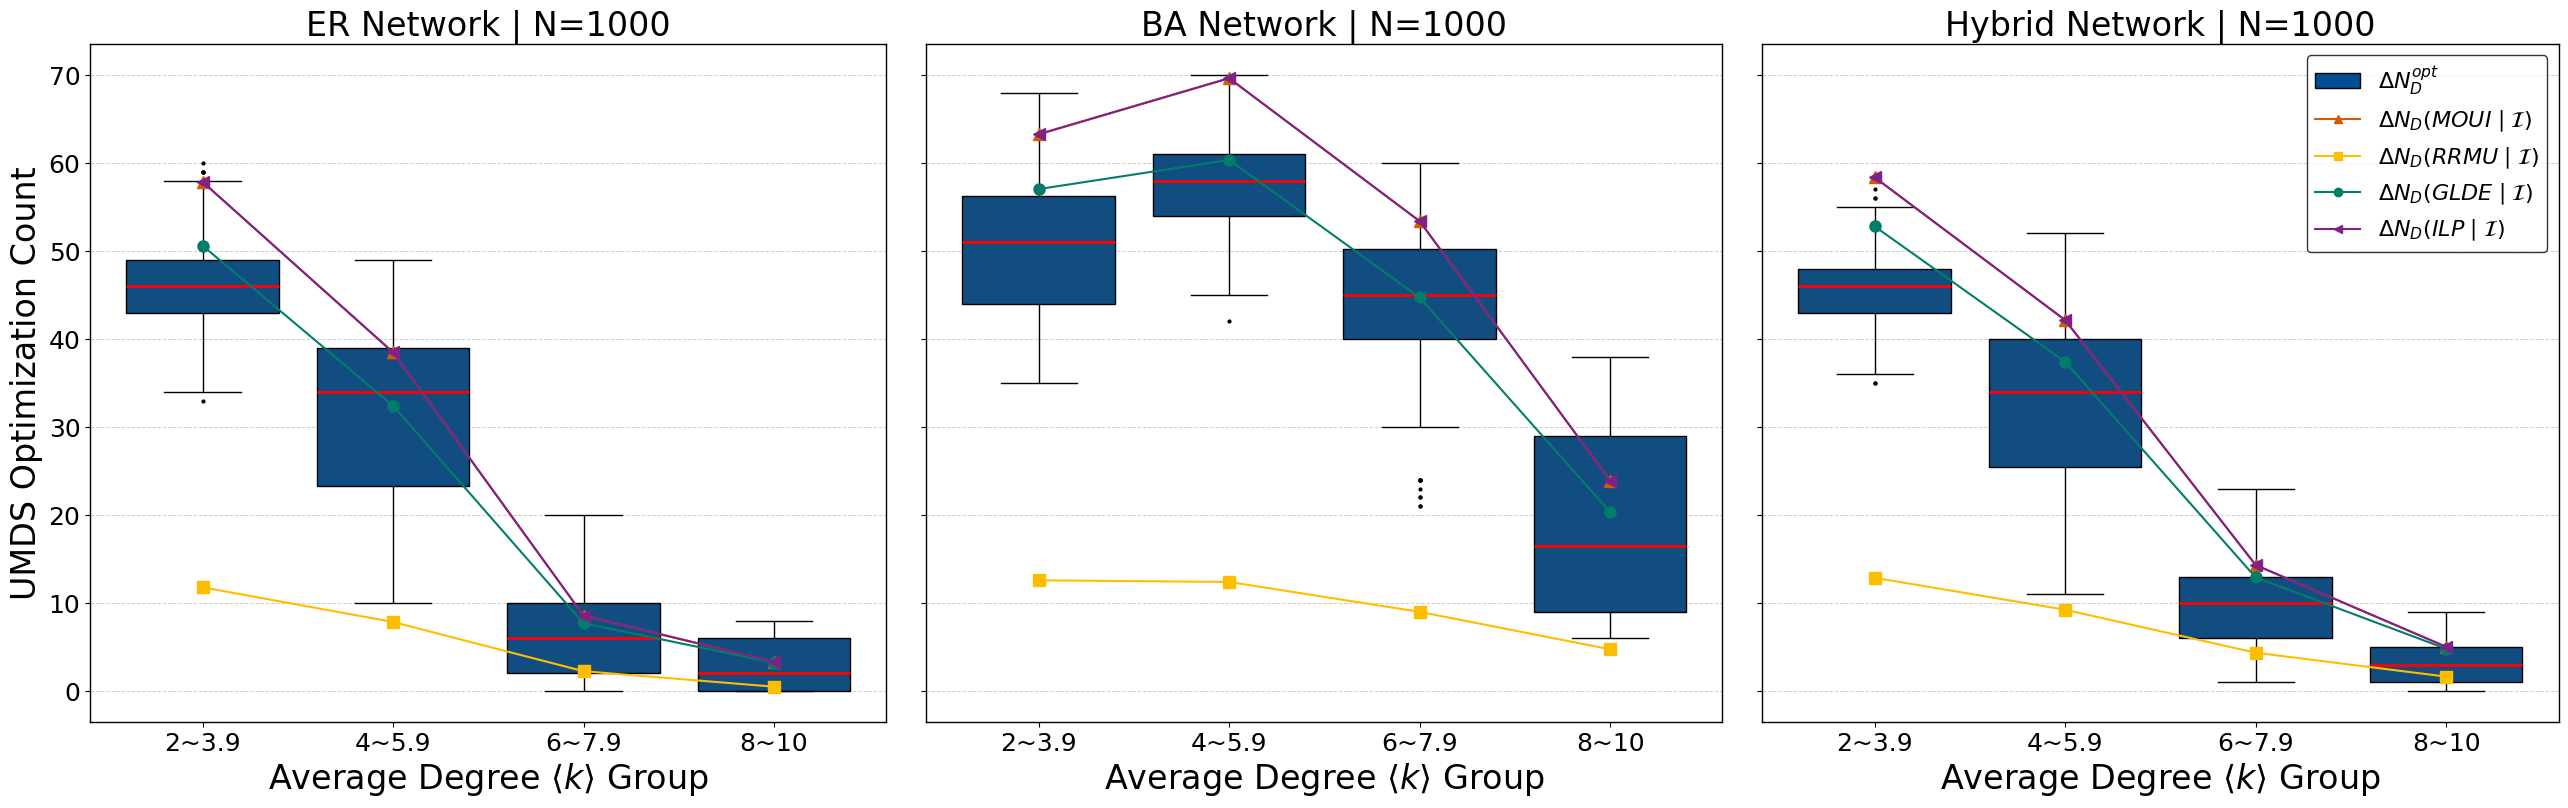

In [11]:
# Load data
df = pd.read_csv(RESULT_PATH / "optimization_amount.csv")

# Network type mapping
network_type_mapping = {
    "ER+ER": "ER",
    "BA+BA": "BA",
    "ER+BA": "Hybrid"
}
df['network_type_display'] = df['network_type'].map(network_type_mapping)

# Calculate optimization metrics
df['Opt_vs_Baseline'] = df['UMDS_RRMU'] - df['UMDS_MOUI']  # Existing comparison
df['Opt_MOUI'] = df['UMDS_0'] - df['UMDS_MOUI']         # MOUI optimization
df['Opt_RRMU'] = df['UMDS_0'] - df['UMDS_RRMU']         # RRMU optimization
df['Opt_GLDE'] = df['UMDS_0'] - df['UMDS_GLDE']         # GLDE optimization
df['Opt_ILP'] = df['UMDS_0'] - df['UMDS_ILP']         # ILP optimization

# Define <k> bins/groups
k_edges = [2, 4, 6, 8, 10.1]
k_labels = [f'{k_edges[i]}~{k_edges[i+1]-0.1 if i < len(k_edges)-2 else k_edges[i+1]}' for i in range(len(k_edges)-1)]
k_labels[-1] = f'{k_edges[-2]}~{int(k_edges[-1]-0.1)}'

# Ensure k_labels has the correct number of elements
if len(k_labels) != len(k_edges) - 1:
    k_labels = [f'{k_edges[i]}~{k_edges[i+1]-0.1}' for i in range(len(k_edges)-1)]

df['k_group'] = pd.cut(df['<k>'], bins=k_edges, labels=k_labels, right=False, include_lowest=True)

# Create the base catplot with boxplots
g_opt = sns.catplot(
    data=df,
    x='k_group',
    y='Opt_vs_Baseline',
    row='N',
    col='network_type_display',
    order=k_labels,
    col_order=network_type_mapping.values(),
    kind='box',
    height=8.8, 
    aspect=1.1,
    sharey='row',
    legend=False,
    color=COLOR['blue'],
    medianprops={'color': 'red', 'linewidth': 2},
    boxprops={'edgecolor': 'black', 'linewidth': 1},
    whiskerprops={'color': 'black', 'linewidth': 1},
    capprops={'color': 'black', 'linewidth': 1},
    flierprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 2}
)

# Aggregate data for the line plots
line_data = df.groupby(['N', 'network_type_display', 'k_group'], observed=True)[
    ['Opt_MOUI', 'Opt_RRMU', 'Opt_GLDE', 'Opt_ILP']].mean().reset_index()

# Define styles for the line plots
line_styles = {
    'Opt_MOUI': {'color': COLOR['orange'], 'marker': '^', 'label': r'$\Delta N_D(MOUI \mid \mathcal{I})$'},
    'Opt_RRMU': {'color': COLOR['yellow'], 'marker': 's', 'label': r'$\Delta N_D(RRMU \mid \mathcal{I})$'},
    'Opt_GLDE': {'color': COLOR['green'], 'marker': 'o', 'label': r'$\Delta N_D(GLDE \mid \mathcal{I})$'},
    'Opt_ILP': {'color': COLOR['purple'], 'marker': '<', 'label': r'$\Delta N_D(ILP \mid \mathcal{I})$'}
}

# Add line plots to each subplot
for i, n_val in enumerate(g_opt.row_names):
    for j, net_type in enumerate(g_opt.col_names):
        ax = g_opt.axes[i, j]
        subplot_line_data = line_data[(line_data['N'] == n_val) & 
                                    (line_data['network_type_display'] == net_type)].copy()
        
        if not subplot_line_data.empty:
            subplot_line_data['k_group'] = pd.Categorical(
                subplot_line_data['k_group'], 
                categories=k_labels, 
                ordered=True
            )
            subplot_line_data = subplot_line_data.sort_values('k_group')
            x_coords = subplot_line_data['k_group'].cat.codes
            
            # Plot lines for each algorithm
            for algo in ['Opt_MOUI', 'Opt_RRMU', 'Opt_GLDE', 'Opt_ILP']:
                if algo in subplot_line_data.columns:
                    ax.plot(
                        x_coords, 
                        subplot_line_data[algo], 
                        color=line_styles[algo]['color'], 
                        marker=line_styles[algo]['marker'], 
                        linestyle='-', 
                        linewidth=1.5, 
                        markersize=8, 
                        zorder=10
                    )

# Create a custom legend for the entire figure
legend_handles = [
    Patch(facecolor=COLOR['blue'], edgecolor='black', label=r'$\Delta N_{D}^{opt}$'),
    *[
        Line2D([0], [0], 
               color=line_styles[algo]['color'], 
               marker=line_styles[algo]['marker'], 
               linestyle='-', 
               label=line_styles[algo]['label'])
        for algo in ['Opt_MOUI', 'Opt_RRMU', 'Opt_GLDE', 'Opt_ILP']
    ]
]

# Add the legend to the top-right subplot
ax_legend = g_opt.axes[0, -1]
leg = ax_legend.legend(
    handles=legend_handles, 
    loc='upper right', 
    frameon=True, 
    edgecolor='black', 
    fontsize=LEGEND_FONTSIZE
)
for text in leg.get_texts():
    text.set_fontweight(FONT_WEIGHT)

# Customize plot appearance
g_opt.set_axis_labels(
    r"Average Degree $\langle k \rangle$ Group", 
    "UMDS Optimization Count", 
    fontsize=AXIS_LABEL_FONTSIZE, 
    fontweight=FONT_WEIGHT
)
g_opt.set_titles(r"{col_name} Network | N={row_name}")

# Adjust subplot titles and labels
for i, ax_row in enumerate(g_opt.axes):
    for j, ax in enumerate(ax_row):
        ax.set_title(ax.get_title(), fontsize=TITLE_FONTSIZE, fontweight=FONT_WEIGHT)
        ax.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE)
        ax.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
        
        for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
            ticklabel.set_fontweight(FONT_WEIGHT)
            
        ax.grid(True, axis='y', linestyle='--', alpha=0.6, linewidth=0.7)
        
        if j == 0:
            ax.set_ylabel(ax.get_ylabel(), fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
        else:
            ax.set_ylabel("")
        
        if i == len(g_opt.axes) - 1:
            ax.set_xlabel(ax.get_xlabel(), fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
        else:
            ax.set_xlabel("")

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1)

# Adjust layout
g_opt.figure.subplots_adjust(
    top=0.92, 
    bottom=0.15, 
    left=0.1, 
    right=0.95, 
    hspace=0.2, 
    wspace=0.05
)

# Save the figure
figure_save_path = FIGURE_PATH / "fig.1.optimization_comparison.svg"
g_opt.figure.savefig(figure_save_path, dpi=DPI, bbox_inches='tight')

plt.show()
plt.close(g_opt.figure)

# Result Table 1

In [82]:
# --- Aggregate Time Data (No <k> grouping) ---
# Group by N and network_type only.
# This will average times across all <k> values and all 10 sequences for each (N, type)
time_summary_overall = df.groupby(['N', 'network_type']).agg(
    mean_time_RRMU=('time_1', 'mean'),
    std_time_RRMU=('time_1', 'std'),  # Std across all <k> and sequences
    mean_time_MOUI=('time_2', 'mean'),
    std_time_MOUI=('time_2', 'std')   # Std across all <k> and sequences
).reset_index()

# Round numerical values for better presentation
for col in ['mean_time_RRMU', 'std_time_RRMU', 'mean_time_MOUI', 'std_time_MOUI']:
    time_summary_overall[col] = time_summary_overall[col].round(3) # Adjust rounding

# --- Generate LaTeX Table Code ---

latex_table_str = "\\begin{table}[htbp]\n"
latex_table_str += "\\centering\n"
latex_table_str += "\\caption{Overall Average Execution Time (seconds $\pm$ Standard Deviation) for RRMU (Baseline) and MOUI Algorithms. Times are averaged across all tested average degrees ($\langle k \\rangle$) and 10 repetitions for each network type.}\n"
latex_table_str += "\\label{tab:execution_time_overall}\n"
latex_table_str += "\\begin{tabular}{l l c c}\n" # N, Type, RRMU Time, MOUI Time
latex_table_str += "\\toprule\n"
latex_table_str += "N & Network Type & RRMU Time (s) & MOUI Time (s) \\\\\n"
latex_table_str += "\\midrule\n"

# Populate table rows
for n_val in sorted(time_summary_overall['N'].unique()):
    n_group = time_summary_overall[time_summary_overall['N'] == n_val]
    first_n_row = True
    for index, row in n_group.iterrows(): # Iterate directly as network_type is part of groupby
        n_display = str(int(n_val)) if first_n_row else ""
        
        std_rrmu_display = f"{row['std_time_RRMU']:.3f}" if pd.notna(row['std_time_RRMU']) else "-"
        std_moui_display = f"{row['std_time_MOUI']:.3f}" if pd.notna(row['std_time_MOUI']) else "-"
        mean_rrmu_display = f"{row['mean_time_RRMU']:.3f}" if pd.notna(row['mean_time_RRMU']) else "-"
        mean_moui_display = f"{row['mean_time_MOUI']:.3f}" if pd.notna(row['mean_time_MOUI']) else "-"

        rrmu_time_str = f"{mean_rrmu_display} $\pm$ {std_rrmu_display}"
        moui_time_str = f"{mean_moui_display} $\pm$ {std_moui_display}"
            
        latex_table_str += f"{n_display} & {row['network_type']} & {rrmu_time_str} & {moui_time_str} \\\\\n"
        
        first_n_row = False
    if n_val != sorted(time_summary_overall['N'].unique())[-1]:
        latex_table_str += "\\midrule\n" # Separator between N groups

latex_table_str += "\\bottomrule\n"
latex_table_str += "\\end{tabular}%\n"
latex_table_str += "\\end{table}\n"

# Print or save the LaTeX table string
print("\n--- LaTeX Table Code (Overall Average Times) ---\n")
print(latex_table_str)

table_save_path_overall = FIGURE_PATH / "tab.1.execution_time_table_overall.tex"
with open(table_save_path_overall, "w") as f:
    f.write(latex_table_str)
print(f"\nLaTeX table code (overall) saved to {table_save_path_overall}")


--- LaTeX Table Code (Overall Average Times) ---

\begin{table}[htbp]
\centering
\caption{Overall Average Execution Time (seconds $\pm$ Standard Deviation) for RRMU (Baseline) and MOUI Algorithms. Times are averaged across all tested average degrees ($\langle k \rangle$) and 10 repetitions for each network type.}
\label{tab:execution_time_overall}
\begin{tabular}{l l c c}
\toprule
N & Network Type & RRMU Time (s) & MOUI Time (s) \\
\midrule
1000 & BA+BA & 0.907 $\pm$ 0.363 & 0.059 $\pm$ 0.041 \\
 & ER+BA & 0.912 $\pm$ 0.329 & 0.016 $\pm$ 0.009 \\
 & ER+ER & 0.923 $\pm$ 0.321 & 0.032 $\pm$ 0.023 \\
\bottomrule
\end{tabular}%
\end{table}


LaTeX table code (overall) saved to ../assets/result/figure/tab.1.execution_time_table_overall.tex


In [12]:
# --- Aggregate Time Data (No <k> grouping) ---
# Group by N and network_type only.
# This will average times across all <k> values and all 10 sequences for each (N, type)
time_summary_overall = df.groupby(['N', 'network_type']).agg(
    mean_time_RRMU=('time_RRMU', 'mean'),
    std_time_RRMU=('time_RRMU', 'std'),
    mean_time_MOUI=('time_MOUI', 'mean'),
    std_time_MOUI=('time_MOUI', 'std'),
    mean_time_GLDE=('time_GLDE', 'mean'),
    std_time_GLDE=('time_GLDE', 'std'),
    mean_time_ILP=('time_ILP', 'mean'),
    std_time_ILP=('time_ILP', 'std')
).reset_index()

# Round numerical values for better presentation
time_cols = ['mean_time_RRMU', 'std_time_RRMU', 
             'mean_time_MOUI', 'std_time_MOUI',
             'mean_time_GLDE', 'std_time_GLDE',
             'mean_time_ILP', 'std_time_ILP']

for col in time_cols:
    time_summary_overall[col] = time_summary_overall[col].round(3)

# --- Generate LaTeX Table Code ---
latex_table_str = "\\begin{table}[htbp]\n"
latex_table_str += "\\centering\n"
latex_table_str += "\\caption{Overall Average Execution Time (seconds $\pm$ Standard Deviation) for Different Algorithms. Times are averaged across all tested average degrees ($\langle k \\rangle$) and 10 repetitions for each network type.}\n"
latex_table_str += "\\label{tab:execution_time_overall}\n"
latex_table_str += "\\begin{tabular}{l l c c c c}\n"  # N, Type, RRMU, MOUI, GLDE, ILP
latex_table_str += "\\toprule\n"
latex_table_str += "N & Network Type & RRMU (s) & MOUI (s) & GLDE (s) & ILP (s) \\\\\n"
latex_table_str += "\\midrule\n"

# Function to format time with standard deviation
def format_time(mean, std):
    if pd.isna(mean) or pd.isna(std):
        return "-"
    return f"{mean:.3f} $\pm$ {std:.3f}"

# Populate table rows
for n_val in sorted(time_summary_overall['N'].unique()):
    n_group = time_summary_overall[time_summary_overall['N'] == n_val]
    first_n_row = True
    for index, row in n_group.iterrows():
        n_display = str(int(n_val)) if first_n_row else ""
        
        # Format each algorithm's time
        rrmu_time = format_time(row['mean_time_RRMU'], row['std_time_RRMU'])
        moui_time = format_time(row['mean_time_MOUI'], row['std_time_MOUI'])
        glde_time = format_time(row['mean_time_GLDE'], row['std_time_GLDE'])
        ilp_time = format_time(row['mean_time_ILP'], row['std_time_ILP'])
            
        latex_table_str += f"{n_display} & {row['network_type']} & {rrmu_time} & {moui_time} & {glde_time} & {ilp_time} \\\\\n"
        
        first_n_row = False
    if n_val != sorted(time_summary_overall['N'].unique())[-1]:
        latex_table_str += "\\midrule\n"  # Separator between N groups

latex_table_str += "\\bottomrule\n"
latex_table_str += "\\end{tabular}%\n"
latex_table_str += "\\end{table}\n"

# Print or save the LaTeX table string
print("\n--- LaTeX Table Code (Overall Average Times) ---\n")
print(latex_table_str)

table_save_path_overall = FIGURE_PATH / "tab.1.execution_time_table_overall.tex"
with open(table_save_path_overall, "w") as f:
    f.write(latex_table_str)
print(f"\nLaTeX table code (overall) saved to {table_save_path_overall}")


--- LaTeX Table Code (Overall Average Times) ---

\begin{table}[htbp]
\centering
\caption{Overall Average Execution Time (seconds $\pm$ Standard Deviation) for Different Algorithms. Times are averaged across all tested average degrees ($\langle k \rangle$) and 10 repetitions for each network type.}
\label{tab:execution_time_overall}
\begin{tabular}{l l c c c c}
\toprule
N & Network Type & RRMU (s) & MOUI (s) & GLDE (s) & ILP (s) \\
\midrule
1000 & BA+BA & 0.796 $\pm$ 0.316 & 0.060 $\pm$ 0.045 & 0.013 $\pm$ 0.005 & 0.737 $\pm$ 0.262 \\
 & ER+BA & 1.137 $\pm$ 0.922 & 0.017 $\pm$ 0.009 & 0.008 $\pm$ 0.005 & 0.820 $\pm$ 0.410 \\
 & ER+ER & 1.383 $\pm$ 1.287 & 0.034 $\pm$ 0.027 & 0.008 $\pm$ 0.005 & 0.844 $\pm$ 0.499 \\
\bottomrule
\end{tabular}%
\end{table}


LaTeX table code (overall) saved to ../assets/result/figure/tab.1.execution_time_table_overall.tex


# Result Figure 2

75
Saved robust combo plot to ../assets/result/figure/fig.2.optimization_combo_ER_N1000_robust.svg


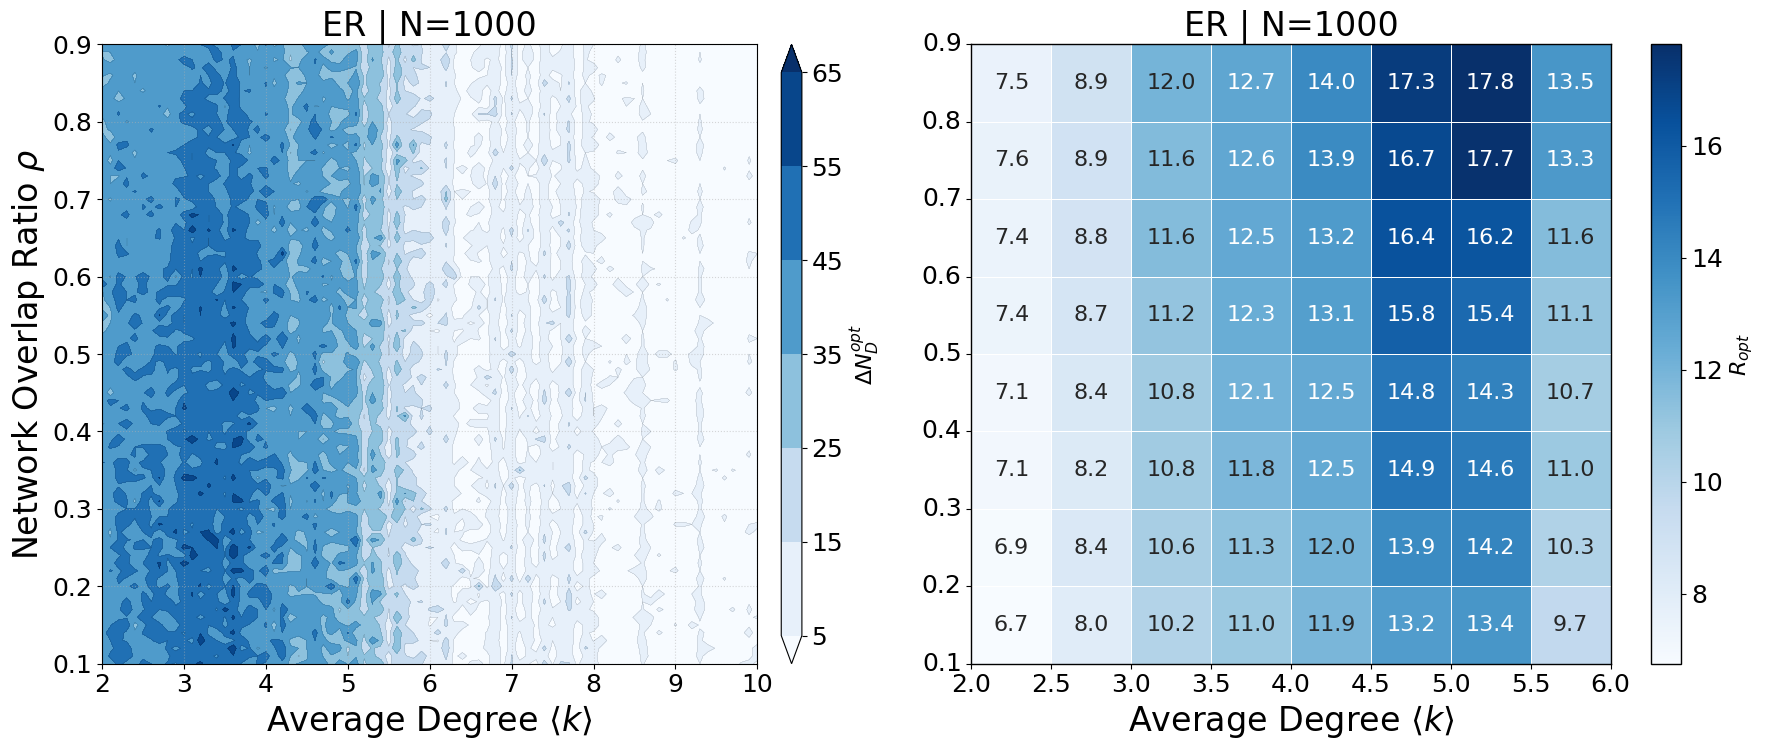

Saved robust combo plot to ../assets/result/figure/fig.2.optimization_combo_BA_N1000_robust.svg


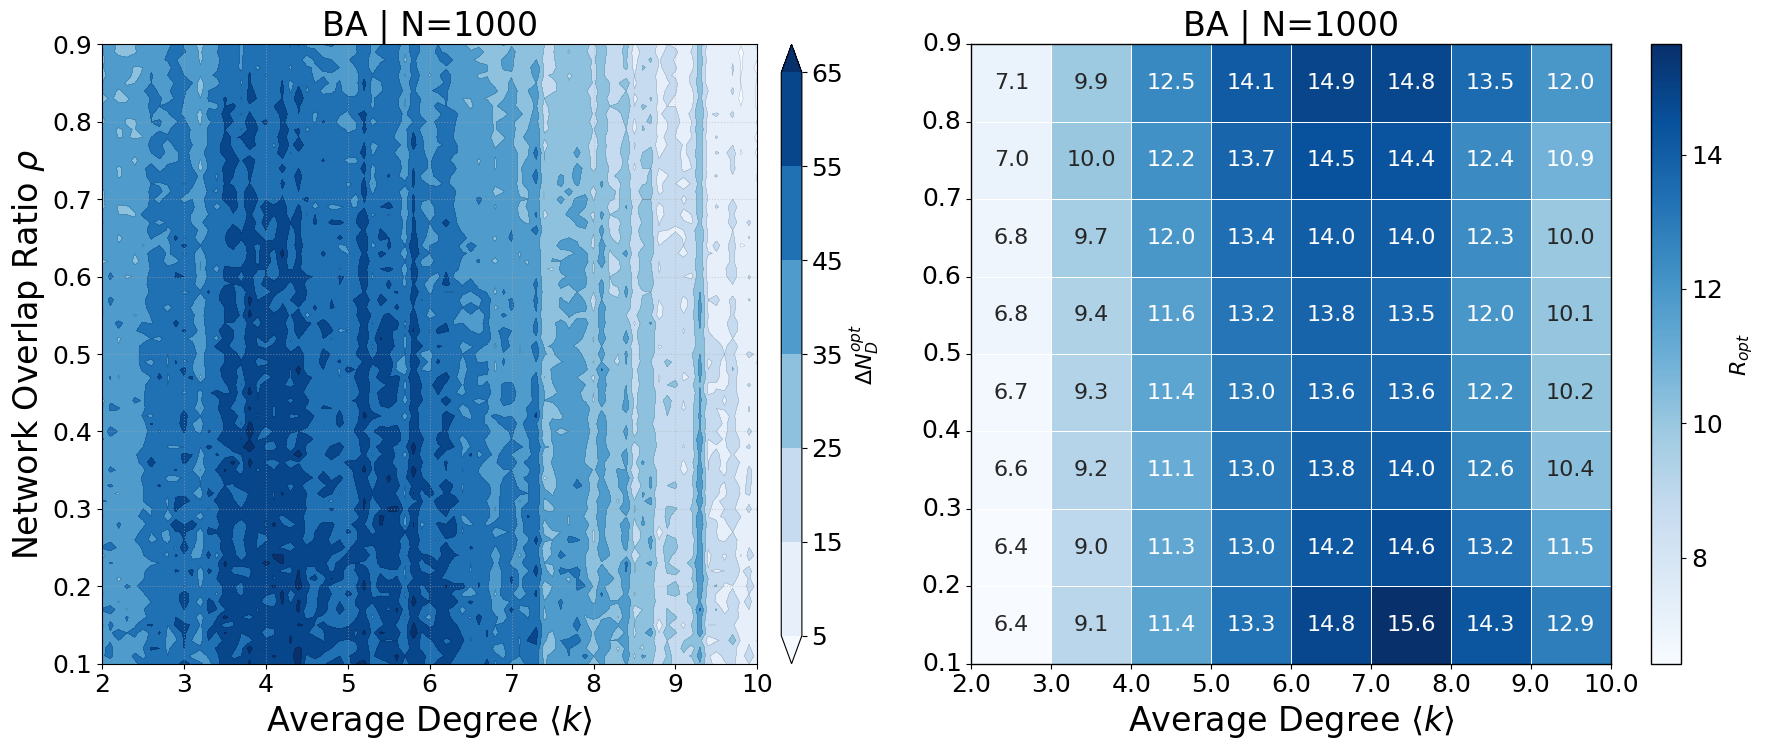

All robust combo plots generated.


In [92]:
df_prop = pd.read_csv(RESULT_PATH / "optimization_proportion.csv")

df_prop['network_type_display'] = df_prop['network_type'].map(network_type_mapping)

# Calculate Optimization Count (Absolute)
df_prop['Opt_Count'] = df_prop['UMDS_1'] - df_prop['UMDS_2']

# Calculate Optimization Rate (%)
df_prop['Opt_Rate'] = (df_prop['UMDS_1'] - df_prop['UMDS_2']) / df_prop['UMDS_1'] * 100
df_prop['Opt_Rate'].replace([np.inf, -np.inf, 0], 0, inplace=True) # Replace 0s too if UMDS_1=UMDS_2

print(df_prop['Opt_Count'].max())

# pandas在Jupyter中最大显示行数改为100
pd.set_option('display.max_rows', 100)

N_val = 1000 # Focusing on N=1000

# --- Plotting Loop for each Network Type ---
for original_net_type, display_net_type in network_type_mapping.items():
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8)) # Two subplots side-by-side
    ax1.set_title(f"{display_net_type} | N={N_val}", fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    ax2.set_title(f"{display_net_type} | N={N_val}", fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)

    subset_df_type = df_prop[(df_prop['network_type'] == original_net_type) & (df_prop['N'] == N_val)].copy()

    if subset_df_type.empty:
        print(f"No data for {display_net_type} (N={N_val}). Skipping.")
        plt.close(fig)
        continue

    # === Left Subplot (ax1): Contour Plot for Optimization Count ===
    
    # Prepare data for contour plot (pivot and ensure regular grid or interpolate)
    # Using original <k> and overlap for finer granularity if desired for contour
    try:
        pivot_count = subset_df_type.pivot_table(index='overlap', columns='<k>', values='Opt_Count', aggfunc='mean')
        pivot_count.sort_index(axis=0, inplace=True) # Sort overlap (y-axis)
        pivot_count.sort_index(axis=1, inplace=True) # Sort <k> (x-axis)
        
        X_k = pivot_count.columns.values
        Y_overlap = pivot_count.index.values
        Z_count = pivot_count.values

        # Set fixed contour levels as requested by the user
        levels_count = [5, 15, 25, 35, 45, 55, 65]
        # Use 'extend' to handle values that fall outside the specified range
        extend_opt = 'both'

        # Filled contour plot with the specified levels
        contour1 = ax1.contourf(X_k, Y_overlap, Z_count, levels=levels_count, cmap="Blues", extend=extend_opt)
        
        # Create and configure the colorbar, ensuring its ticks match the levels
        cbar1 = fig.colorbar(contour1, ax=ax1, orientation='vertical', pad=0.03, aspect=30)
        cbar1.set_ticks(levels_count) # Explicitly set ticks to match your list
        cbar1.set_label(r'$\Delta N_{D}^{opt}$', fontsize=LEGEND_FONTSIZE, fontweight=FONT_WEIGHT, ha='center', va='top')
        cbar1.ax.tick_params(labelsize=AXIS_TICK_FONTSIZE)
        for t in cbar1.ax.get_yticklabels(): t.set_fontweight(FONT_WEIGHT)

        # Add contour lines for better definition, using the same fixed levels
        contour_lines1 = ax1.contour(X_k, Y_overlap, Z_count, levels=levels_count, colors='black', linewidths=0.1, alpha=0.7)
        # ax1.clabel(contour_lines1, inline=True, fontsize=TICK_FONTSIZE-4, fmt='%1.1f')


    except Exception as e:
        print(f"Could not create contour plot for Opt_Count on {display_net_type}: {e}")
        ax1.text(0.5, 0.5, "Data error for contour plot", ha='center', va='center', fontsize=12, color='red')


    ax1.set_xlabel(r"Average Degree $\langle k \rangle$", fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    ax1.set_ylabel(r"Network Overlap Ratio $\rho$", fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    ax1.tick_params(axis='both', labelsize=AXIS_TICK_FONTSIZE)
    for ticklabel in ax1.get_xticklabels() + ax1.get_yticklabels(): ticklabel.set_fontweight(FONT_WEIGHT)
    ax1.grid(True, linestyle=':', alpha=0.5)


    # === Right Subplot (ax2): Heatmap for Optimization Rate ===

    if original_net_type == 'ER+ER':
        k_min_heatmap, k_max_heatmap, k_step_heatmap = 2.0, 6.0, 0.5
    elif original_net_type == 'BA+BA':
        k_min_heatmap, k_max_heatmap, k_step_heatmap = 2.0, 10.0, 1.0

    subset_df_heatmap = subset_df_type[
        (subset_df_type['<k>'] >= k_min_heatmap) & (subset_df_type['<k>'] < k_max_heatmap + k_step_heatmap) # Ensure we capture up to k_max_heatmap correctly
    ].copy()


    if subset_df_heatmap.empty:
        ax2.text(0.5, 0.5, f"No data for k in range", ha='center', va='center', fontsize=12, color='red')
    else:
        # k bins for heatmap
        k_bin_edges_hm = np.arange(k_min_heatmap, k_max_heatmap + k_step_heatmap, k_step_heatmap)
        k_bin_edges_hm = np.unique(k_bin_edges_hm)
        if len(k_bin_edges_hm) < 2: k_bin_edges_hm = np.array([k_min_heatmap, k_max_heatmap + k_step_heatmap])
        
        # Labels for pivot table columns will be the left edge of the bin
        k_pivot_labels_hm = [k_bin_edges_hm[i] for i in range(len(k_bin_edges_hm)-1)]
        subset_df_heatmap['k_binned_hm'] = pd.cut(subset_df_heatmap['<k>'], bins=k_bin_edges_hm, labels=k_pivot_labels_hm, right=False, include_lowest=True)

        # Overlap bins for heatmap
        overlap_bin_edges_hm = np.arange(0.1, 0.9 + 0.1, 0.1) 
        overlap_pivot_labels_hm = [overlap_bin_edges_hm[i] for i in range(len(overlap_bin_edges_hm)-1)]
        subset_df_heatmap['overlap_binned_hm'] = pd.cut(subset_df_heatmap['overlap'], bins=overlap_bin_edges_hm, labels=overlap_pivot_labels_hm, right=False, include_lowest=True)
        
        subset_df_heatmap.dropna(subset=['k_binned_hm', 'overlap_binned_hm', 'Opt_Rate'], inplace=True)

        if subset_df_heatmap.empty:
            ax2.text(0.5, 0.5, "No binnable data for heatmap", ha='center', va='center', fontsize=12, color='red')
        else:
            try:
                # 先聚合UMDS_1和UMDS_2的总和
                aggregated_data = subset_df_heatmap.groupby(['overlap_binned_hm', 'k_binned_hm'], observed=False).agg(
                    UMDS_1_sum=('UMDS_1', 'sum'),
                    UMDS_2_sum=('UMDS_2', 'sum')
                ).reset_index()

                # 基于聚合后的值计算优化率，避免除以零的错误
                aggregated_data['Opt_Rate_Aggregated'] = np.where(
                    aggregated_data['UMDS_1_sum'] > 0,
                    (aggregated_data['UMDS_1_sum'] - aggregated_data['UMDS_2_sum']) / aggregated_data['UMDS_1_sum'] * 100,
                    0
                )

                # 将数据整理成热力图需要的二维格式 (Pivot)
                heatmap_data_rate = aggregated_data.pivot(index='overlap_binned_hm',
                                                          columns='k_binned_hm',
                                                          values='Opt_Rate_Aggregated')
                
                # 确保行列顺序正确
                heatmap_data_rate.sort_index(axis=0, ascending=True, inplace=True) 
                heatmap_data_rate.sort_index(axis=1, ascending=True, inplace=True)

                # 绘制热力图
                sns.heatmap(heatmap_data_rate,
                            ax=ax2,
                            annot=True, fmt=".1f", 
                            cmap="Blues",
                            cbar_kws={'label': r'$R_{opt}$'},
                            linewidths=0.5, linecolor='white',
                            annot_kws={"fontsize": AXIS_TICK_FONTSIZE - 2, "fontweight": FONT_WEIGHT})


                cbar2 = ax2.collections[0].colorbar
                cbar2.set_label(r'$R_{opt}$', fontsize=LEGEND_FONTSIZE, fontweight=FONT_WEIGHT, ha='center', va='top')
                cbar2.ax.tick_params(labelsize=AXIS_TICK_FONTSIZE)
                for t in cbar2.ax.get_yticklabels(): t.set_fontweight(FONT_WEIGHT)
                cbar2.outline.set_edgecolor('black')
                cbar2.outline.set_linewidth(1)

                for spine in ax2.spines.values():
                    spine.set_visible(True)
                    spine.set_edgecolor('black')
                    spine.set_linewidth(1)
                
                # --- Custom X and Y Ticks for Heatmap (Edges of Bins) ---
                # X-axis ticks (k_bin_edges_hm are the actual boundaries)
                # Number of cells = len(heatmap_data_rate.columns)
                # Number of edges = len(k_bin_edges_hm)
                ax2.set_xticks(np.arange(len(k_bin_edges_hm))) # Tick positions at 0, 1, 2, ... (for edges)
                ax2.set_xticklabels([f"{val:.1f}" for val in k_bin_edges_hm], fontsize=AXIS_TICK_FONTSIZE, fontweight=FONT_WEIGHT, rotation=0)
                
                # Y-axis ticks (overlap_bin_edges_hm are the actual boundaries)
                # Number of cells = len(heatmap_data_rate.index)
                # Number of edges = len(overlap_bin_edges_hm)
                ax2.set_yticks(np.arange(len(overlap_bin_edges_hm))) # Tick positions at 0, 1, 2, ...
                ax2.set_yticklabels([f"{val:.1f}" for val in overlap_bin_edges_hm], fontsize=AXIS_TICK_FONTSIZE, fontweight=FONT_WEIGHT, rotation=0)
                
                ax2.invert_yaxis() # To have 0.1 overlap at the bottom

            except Exception as e:
                print(f"Could not create heatmap for Opt_Rate on {display_net_type}: {e}")
                ax2.text(0.5, 0.5, "Data error for heatmap", ha='center', va='center', fontsize=12, color='red')

    ax2.set_xlabel(r"Average Degree $\langle k \rangle$", fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    ax2.set_ylabel("") 
    ax2.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE) # Adjusted tick font size
    ax2.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE) # Adjusted tick font size
    # Boldness for ticks already handled by direct set_xticklabels/set_yticklabels with fontweight
    ax2.grid(False) 


    # --- Final Adjustments and Save ---
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    figure_save_path_combo = FIGURE_PATH / f"fig.2.optimization_combo_{display_net_type}_N{N_val}_robust.svg"
    fig.savefig(figure_save_path_combo, dpi=DPI, bbox_inches='tight')
    print(f"Saved robust combo plot to {figure_save_path_combo}")
    plt.show()
    plt.close(fig)

print("All robust combo plots generated.")

# Result Figure 1.1

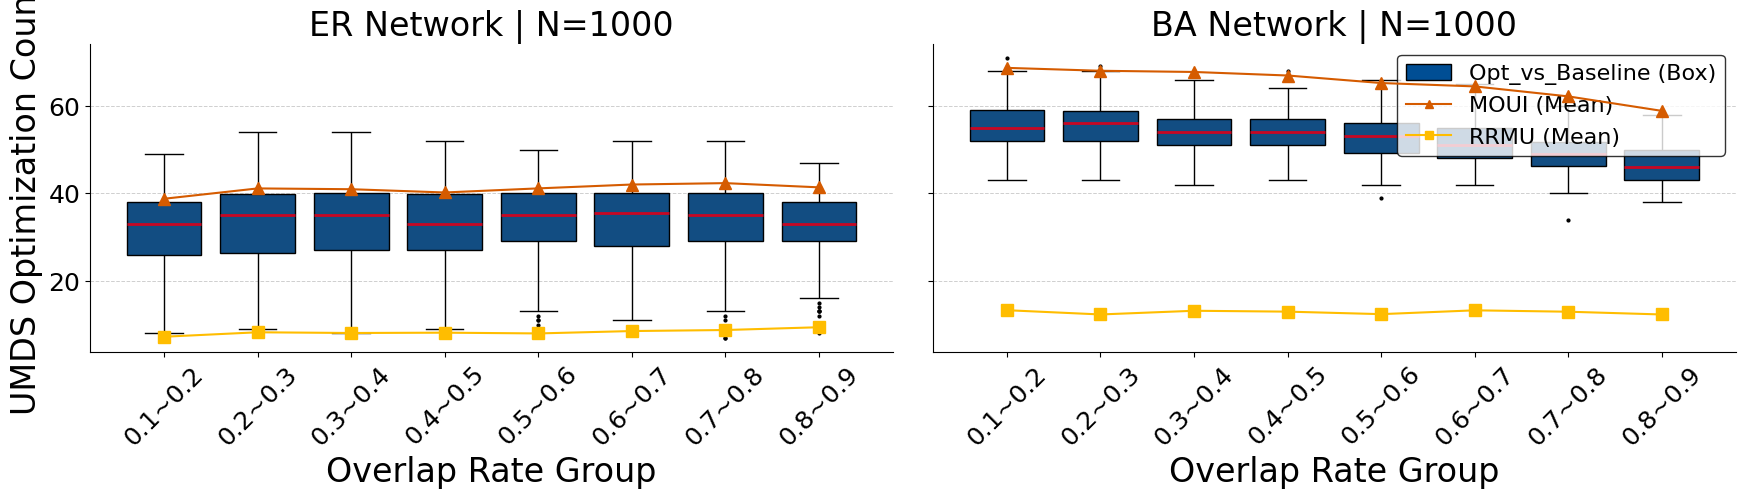

图表已保存至: ../assets/result/figure/optimization_vs_overlap_k5.svg


In [84]:
# 2. 筛选 k=5 的数据
df_k5 = df_prop[(4.5 <= df_prop['<k>']) & (df_prop['<k>'] <= 5.5)].copy()

if df_k5.empty:
    print("在数据中未找到 <k>=5 的条目。无法生成图表。")
else:
    # 3. 计算优化指标
    df_k5['Opt_vs_Baseline'] = df_k5['UMDS_1'] - df_k5['UMDS_2']
    df_k5['Opt_MOUI'] = df_k5['UMDS_0'] - df_k5['UMDS_2']
    df_k5['Opt_RRMU'] = df_k5['UMDS_0'] - df_k5['UMDS_1']

    # Network type mapping
    network_type_mapping = {
        "ER+ER": "ER",
        "BA+BA": "BA",
    }
    df_k5['network_type_display'] = df_k5['network_type'].map(network_type_mapping)

    # 4. 将重叠率分为4组
    overlap_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.91] # 使用1.01确保1.0被包含
    overlap_labels = [f'{overlap_edges[i]}~{overlap_edges[i+1]}' for i in range(len(overlap_edges)-1)]
    overlap_labels[-1] = '0.8~0.9' # 修正最后一个标签
    df_k5['overlap_group'] = pd.cut(df_k5['overlap'], bins=overlap_edges, labels=overlap_labels, right=False, include_lowest=True)

    # --- 5. 绘图 ---
    box_color = COLOR['blue']
    median_color = COLOR['red']

    g_overlap = sns.catplot(
        data=df_k5,
        x='overlap_group',
        y='Opt_vs_Baseline',
        row='N',
        col='network_type_display',
        order=overlap_labels,
        col_order=network_type_mapping.values(),
        kind='box',
        height=4.4, aspect=2.2,
        sharey='row',
        legend=False,
        color=box_color,
        medianprops={'color': median_color, 'linewidth': 2},
        boxprops={'edgecolor': 'black', 'linewidth': 1},
        whiskerprops={'color': 'black', 'linewidth': 1},
        capprops={'color': 'black', 'linewidth': 1},
        flierprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 2}
    )

    # --- 添加线图 ---
    line_data_overlap = df_k5.groupby(['N', 'network_type_display', 'overlap_group'], observed=True)[['Opt_MOUI', 'Opt_RRMU', 'UMDS_0']].mean().reset_index()
    
    line_styles = {
        'Opt_MOUI': {'color': COLOR['orange'], 'marker': '^', 'label': 'MOUI (Mean)'},
        'Opt_RRMU': {'color': COLOR['yellow'], 'marker': 's', 'label': 'RRMU (Mean)'}
    }

    for i, n_val in enumerate(g_overlap.row_names):
        for j, net_type in enumerate(g_overlap.col_names):
            ax = g_overlap.axes[i, j]
            subplot_line_data = line_data_overlap[(line_data_overlap['N'] == n_val) & (line_data_overlap['network_type_display'] == net_type)].copy()
            
            if not subplot_line_data.empty:
                subplot_line_data['overlap_group'] = pd.Categorical(subplot_line_data['overlap_group'], categories=overlap_labels, ordered=True)
                subplot_line_data = subplot_line_data.sort_values('overlap_group')
                x_coords = subplot_line_data['overlap_group'].cat.codes
                
                ax.plot(x_coords, subplot_line_data['Opt_MOUI'], color=line_styles['Opt_MOUI']['color'], marker=line_styles['Opt_MOUI']['marker'], linestyle='-', linewidth=1.5, markersize=8, zorder=10)
                ax.plot(x_coords, subplot_line_data['Opt_RRMU'], color=line_styles['Opt_RRMU']['color'], marker=line_styles['Opt_RRMU']['marker'], linestyle='-', linewidth=1.5, markersize=8, zorder=5)

    # --- 6. 美化和保存 ---
    legend_handles = [
        Patch(facecolor=box_color, edgecolor='black', label='Opt_vs_Baseline (Box)'),
        Line2D([0], [0], color=line_styles['Opt_MOUI']['color'], marker=line_styles['Opt_MOUI']['marker'], linestyle='-', label=line_styles['Opt_MOUI']['label']),
        Line2D([0], [0], color=line_styles['Opt_RRMU']['color'], marker=line_styles['Opt_RRMU']['marker'], linestyle='-', label=line_styles['Opt_RRMU']['label'])
    ]
    
    ax_legend = g_overlap.axes[0, -1]
    leg = ax_legend.legend(handles=legend_handles, loc='upper right', frameon=True, edgecolor='black', fontsize=LEGEND_FONTSIZE)
    for text in leg.get_texts():
        text.set_fontweight(FONT_WEIGHT)

    g_overlap.set_axis_labels("Overlap Rate Group", "UMDS Optimization Count", fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    g_overlap.set_titles(r"{col_name} Network | N={row_name}")

    for ax_row in g_overlap.axes:
        for ax in ax_row:
            ax.set_title(ax.get_title(), fontsize=TITLE_FONTSIZE, fontweight=FONT_WEIGHT)
            ax.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE, rotation=45)
            # ax.set_ylim(0, 30)
            ax.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
            for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
                ticklabel.set_fontweight(FONT_WEIGHT)
            ax.grid(True, axis='y', linestyle='--', alpha=0.6, linewidth=0.7)

    g_overlap.figure.subplots_adjust(top=0.9, bottom=0.2, left=0.1, right=0.95, hspace=0.3, wspace=0.05)
    
    figure_save_path_overlap = FIGURE_PATH / "optimization_vs_overlap_k5.svg"
    g_overlap.figure.savefig(figure_save_path_overlap, dpi=DPI, bbox_inches='tight')

    plt.show()
    plt.close(g_overlap.figure)
    
    print(f"图表已保存至: {figure_save_path_overlap}")

# Result Figure 3

In [3]:
df = pd.read_csv(RESULT_PATH / "optimization_proportion.csv")
# df = df[df['network_type'] == 'ER+ER']

# Network type mapping for display
network_type_mapping_scatter = {
    "ER+ER": "ER",
    "BA+BA": "BA"
}
df['network_type_display'] = df['network_type'].map(network_type_mapping_scatter)


# Calculate relevant metrics
df['Total_Initial_Diff_MDS'] = df['Diff_MDS_1'] + df['Diff_MDS_2']
# This is the number of nodes MOUI optimized compared to the *initial* simple union
df['Nodes_Optimized_by_MOUI'] = df['UMDS_0'] - df['UMDS_2']

# --- Create Plot ---
fig_scatter, ax_scatter = plt.subplots(figsize=(12, 10)) # Adjusted figsize for better aspect

# Define colors for network types for consistency
palette_scatter = {
    "ER": COLOR['1'],
    "BA": COLOR['2']
}

line_palette_scatter = {
    "ER": COLOR['blue'],
    "BA": COLOR['orange']
}


# Define the desired <k> values for the legend
legend_k_values = [2, 3, 6, 10]
# The size range used in the scatter plot call
s_min, s_max = (20, 200)

# Scatter plot
# Using 'network_type_display' for hue
# '<k>' for size can be very busy if <k> has many values.
# Consider binning <k> for size or using a fixed size for clarity.
# For this example, let's use a fixed size initially, then show how to use <k> for size.
scatter_plot = sns.scatterplot(
    data=df,
    x='Total_Initial_Diff_MDS',
    y='Nodes_Optimized_by_MOUI',
    hue='network_type_display',
    palette=palette_scatter,
    size='<k>',  # Optional: use average degree for point size
    sizes=(s_min, s_max), # Range of point sizes if 'size' is used
    alpha=0.5,
    edgecolor='black', # Add edge to points for better visibility
    linewidth=0.1,
    ax=ax_scatter
)

# --- Trend Lines (Overall and Per Network Type) with Annotations ---
plot_data_scatter = df[['Total_Initial_Diff_MDS', 'Nodes_Optimized_by_MOUI', 'network_type_display']].dropna()

# Define a horizontal offset for the text to avoid edge collision
x_range = plot_data_scatter['Total_Initial_Diff_MDS'].max() - plot_data_scatter['Total_Initial_Diff_MDS'].min()

# Define the style for the text background box
bbox_style = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='lightgray', linewidth=0.5)

# Overall trend line
if not plot_data_scatter.empty:
    slope_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(
        plot_data_scatter['Total_Initial_Diff_MDS'], plot_data_scatter['Nodes_Optimized_by_MOUI']
    )
    x_trend_all = np.array([plot_data_scatter['Total_Initial_Diff_MDS'].min(), plot_data_scatter['Total_Initial_Diff_MDS'].max()])
    y_trend_all = intercept_all + slope_all * x_trend_all
    # Plot line without a label
    ax_scatter.plot(x_trend_all, y_trend_all, color='black', linestyle='--', linewidth=2.5)
    # Add R-squared annotation with the styled background box, shifted left
    ax_scatter.text(x_trend_all[-1], y_trend_all[-1] - 1, f'$R^2={r_value_all**2:.2f}$',
                  color='black', fontsize=AXIS_LABEL_FONTSIZE, ha='right', va='center', fontweight=FONT_WEIGHT,
                  bbox=bbox_style)

# Per-network type trend lines
for net_type_display, color in line_palette_scatter.items():
    type_data = plot_data_scatter[plot_data_scatter['network_type_display'] == net_type_display]
    if len(type_data) > 1: # Need at least 2 points for linregress
        slope, intercept, r_value, p_value, std_err = linregress(
            type_data['Total_Initial_Diff_MDS'], type_data['Nodes_Optimized_by_MOUI']
        )
        x_trend_type = np.array([type_data['Total_Initial_Diff_MDS'].min(), type_data['Total_Initial_Diff_MDS'].max()])
        if len(x_trend_type) > 1 and x_trend_type[0] < x_trend_type[1]:
             y_trend_type = intercept + slope * x_trend_type
             # Plot line without a label
             ax_scatter.plot(x_trend_type, y_trend_type, color=color, linestyle='--', linewidth=2.5)
             # Add R-squared annotation with the styled background box, shifted left
             ax_scatter.text(x_trend_type[-1] + 20, y_trend_type[-1] + (-1 if net_type_display == 'ER' else -3), f'$R^2={r_value**2:.2f}$',
                           color=color, fontsize=AXIS_LABEL_FONTSIZE, ha='right', va='center', fontweight=FONT_WEIGHT,
                           bbox=bbox_style)


# --- Axis Labels, Title, Ticks, Legend, Grid ---
ax_scatter.set_xlabel('Initial Total Difference Count in MDSs', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
ax_scatter.set_ylabel('UMDS Optimization Count of MOUI', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)

ax_scatter.tick_params(axis='both', which='major', labelsize=AXIS_TICK_FONTSIZE)
for ticklabel in ax_scatter.get_xticklabels() + ax_scatter.get_yticklabels():
    ticklabel.set_fontweight(FONT_WEIGHT)

# First, remove any existing legend created by scatterplot to avoid conflicts
if ax_scatter.get_legend():
    ax_scatter.get_legend().remove()

# The data range for <k> from the dataframe
k_min, k_max = df['<k>'].min(), df['<k>'].max()

# Create custom legend handles by calculating marker size for each value
custom_handles = []
for k_val in legend_k_values:
    # Linearly interpolate the marker area from the size range
    if (k_max - k_min) > 0:
        normalized_k = (k_val - k_min) / (k_max - k_min)
    else:
        normalized_k = 0.5 # Handle case where all k are the same
    # Clamp the value between 0 and 1 in case a legend value is outside the data range
    normalized_k = max(0, min(1, normalized_k))
    marker_area = s_min + normalized_k * (s_max - s_min)
    
    # Create a dummy plot object (Line2D) for the handle
    # markersize is the diameter in points, so we need the square root of the area
    custom_handles.append(Line2D([0], [0], marker='o', color='w', # invisible line
                                 markerfacecolor='gray', # neutral marker color
                                 markeredgecolor='black',
                                 markersize=np.sqrt(marker_area),
                                 label=str(k_val)))

# Create the new, custom legend
if custom_handles:
    leg = ax_scatter.legend(handles=custom_handles,
                          title=r'Degree $\langle k \rangle$', # Use a descriptive title with LaTeX
                          title_fontsize=LEGEND_FONTSIZE,
                          fontsize=LEGEND_FONTSIZE,
                          loc='lower right', frameon=True, shadow=False, edgecolor='black')
    # Style legend text and title
    for text in leg.get_texts():
        text.set_fontweight(FONT_WEIGHT)
    if leg.get_title():
        leg.get_title().set_fontweight(FONT_WEIGHT)
        leg.get_title().set_fontsize(LEGEND_FONTSIZE)


# --- Final Adjustments and Save ---
plt.tight_layout(rect=[0, 0, 0.95, 0.95]) # Adjust rect if legend is outside
figure_save_path_scatter = FIGURE_PATH / "fig.3.initial_diff_vs_optimized_nodes_scatter.png"
fig_scatter.savefig(figure_save_path_scatter, dpi=DPI, bbox_inches='tight')
print(f"Saved scatter plot to {figure_save_path_scatter}")

plt.show()
plt.close(fig_scatter)

print("Scatter plot generated.")

KeyError: 'UMDS_2'

Slope: 0.17, Intercept: 1.95, R-value: 0.9, P-value: 0.0, Std-error: 0.0
Slope: 0.14, Intercept: 16.53, R-value: 0.74, P-value: 0.0, Std-error: 0.0
Saved scatter plot to ../assets/result/figure/fig.3.initial_diff_vs_optimized_nodes_subplots_with_bound.svg


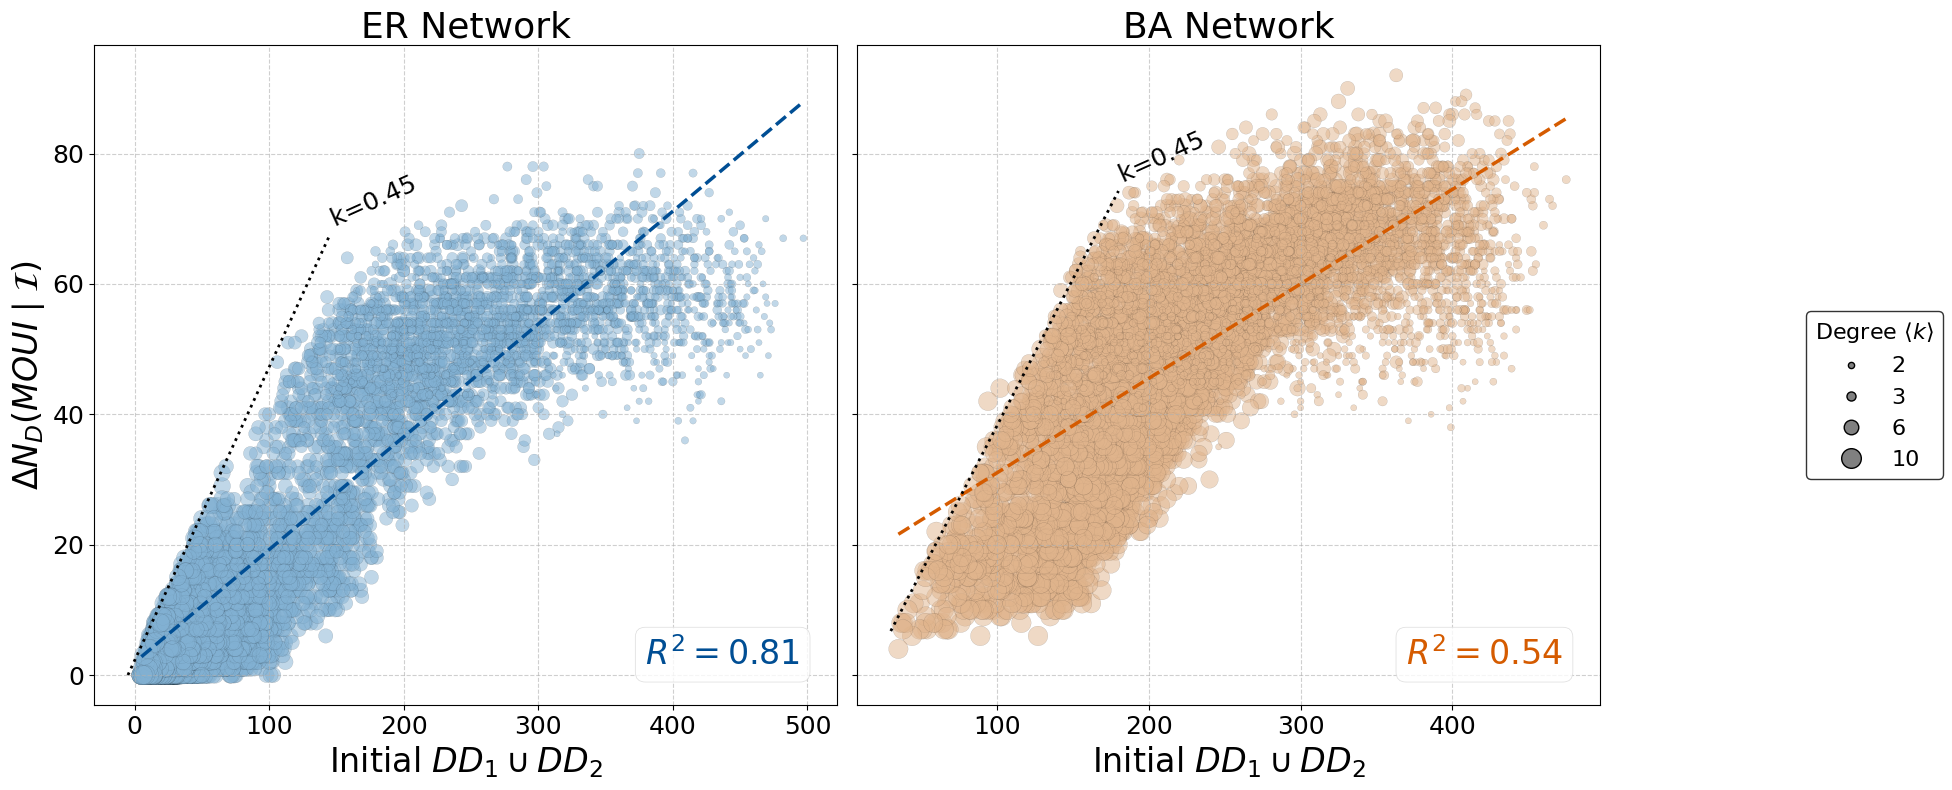

Scatter plot with subplots and manually controlled upper bound line generated.


In [91]:
df = pd.read_csv(RESULT_PATH / "optimization_proportion.csv")

# 网络类型映射以供显示
network_type_mapping_scatter = {
    "ER+ER": "ER",
    "BA+BA": "BA"
}
df['network_type_display'] = df['network_type'].map(network_type_mapping_scatter)
df = df.dropna(subset=['network_type_display']) # 删除映射后可能产生的空值行

# 计算相关指标
df['Total_Initial_Diff_MDS'] = df['Diff_MDS_1'] + df['Diff_MDS_2']
df['Nodes_Optimized_by_MOUI'] = df['UMDS_0'] - df['UMDS_2']

# --- 新增：手动设置上界线的斜率和长度 ---
# 您可以手动调整这个值来改变上界线
upper_bound_slope = 0.45
# 您可以手动设置上界线在 x 轴的终点
upper_bound_x_end = 150 # 调整此值以改变线的长度

# --- 创建包含子图的绘图 ---
fig_scatter, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# 为网络类型定义一致的颜色
palette_scatter = {
    "ER": COLOR['1'],
    "BA": COLOR['2']
}
line_palette_scatter = {
    "ER": COLOR['blue'],
    "BA": COLOR['orange']
}

# 定义图例中期望的 <k> 值
legend_k_values = [2, 3, 6, 10]
# 散点图中使用的大小范围
s_min, s_max = (20, 200)

# 准备两个子图的数据
er_data = df[df['network_type_display'] == 'ER']
ba_data = df[df['network_type_display'] == 'BA']
plot_configs = [
    {'ax': axes[0], 'data': er_data, 'title': 'ER Network', 'net_type': 'ER'},
    {'ax': axes[1], 'data': ba_data, 'title': 'BA Network', 'net_type': 'BA'}
]

# --- 循环生成子图 ---
for config in plot_configs:
    ax = config['ax']
    data = config['data']
    net_type = config['net_type']
    
    if data.empty:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
        ax.set_title(config['title'], fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
        continue

    # 绘制散点图
    sns.scatterplot(
        data=data,
        x='Total_Initial_Diff_MDS',
        y='Nodes_Optimized_by_MOUI',
        color=palette_scatter[net_type],
        size='<k>',
        sizes=(s_min, s_max),
        alpha=0.5,
        edgecolor='black',
        linewidth=0.1,
        ax=ax,
        legend=False
    )

    # --- 趋势线与注释 ---
    plot_data_scatter = data[['Total_Initial_Diff_MDS', 'Nodes_Optimized_by_MOUI']].dropna()
    bbox_style = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='lightgray', linewidth=0.5)

    if len(plot_data_scatter) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(
            plot_data_scatter['Total_Initial_Diff_MDS'], plot_data_scatter['Nodes_Optimized_by_MOUI']
        )
        print(f"Slope: {round(slope, 2)}, Intercept: {round(intercept, 2)}, R-value: {round(r_value, 2)}, P-value: {round(p_value, 2)}, Std-error: {round(std_err, 2)}")
        x_trend = np.array([plot_data_scatter['Total_Initial_Diff_MDS'].min(), plot_data_scatter['Total_Initial_Diff_MDS'].max()])
        if len(x_trend) > 1 and x_trend[0] < x_trend[1]:
            y_trend = intercept + slope * x_trend
            ax.plot(x_trend, y_trend, color=line_palette_scatter[net_type], linestyle='--', linewidth=2.5)
            ax.text(0.95, 0.05, f'$R^2={r_value**2:.2f}$',
                    transform=ax.transAxes,
                    color=line_palette_scatter[net_type], fontsize=AXIS_LABEL_FONTSIZE, ha='right', va='bottom', fontweight=FONT_WEIGHT,
                    bbox=bbox_style)

    # --- 更新：使用手动设置的终点绘制上界线 ---
    if not data.empty:
        # 使用手动设置的 x 轴终点
        x_bound = np.array([-5 if net_type == 'ER' else 30, upper_bound_x_end + (-5 if net_type == 'ER' else 30)])
        y_bound = upper_bound_slope * (x_bound - (-5 if net_type == 'ER' else 15))
        # 绘制黑色虚线
        ax.plot(x_bound, y_bound, color='black', linestyle=':', linewidth=2)
        # 计算旋转角度以匹配斜线
        angle = np.degrees(np.arctan(upper_bound_slope))
        # 在斜线末端添加文本
        ax.text(x_bound[1], y_bound[1], f' k={upper_bound_slope}', 
                fontsize=AXIS_TICK_FONTSIZE, 
                fontweight=FONT_WEIGHT, 
                color='black',
                ha='left',      # 水平对齐到文本左侧
                va='bottom',    # 垂直对齐到文本底部
                rotation=angle, # 旋转文本
                rotation_mode='anchor')


    # --- 坐标轴标签、标题、刻度 ---
    ax.set_xlabel(r'Initial $DD_1 \cup DD_2$', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    ax.set_title(config['title'], fontsize=AXIS_LABEL_FONTSIZE + 2, fontweight=FONT_WEIGHT)
    ax.tick_params(axis='both', which='major', labelsize=AXIS_TICK_FONTSIZE)
    for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
        ticklabel.set_fontweight(FONT_WEIGHT)
    ax.grid(True, linestyle='--', alpha=0.6)


# --- 共享的 Y 轴标签 ---
axes[0].set_ylabel(r'$\Delta N_D(MOUI \mid \mathcal{I})$', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)


# --- 为整个 Figure 创建并放置一个统一的图例 ---
k_min, k_max = df['<k>'].min(), df['<k>'].max()
custom_handles = []
for k_val in legend_k_values:
    if (k_max - k_min) > 0:
        normalized_k = (k_val - k_min) / (k_max - k_min)
    else:
        normalized_k = 0.5
    normalized_k = max(0, min(1, normalized_k))
    marker_area = s_min + normalized_k * (s_max - s_min)
    custom_handles.append(Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor='gray',
                                 markeredgecolor='black',
                                 markersize=np.sqrt(marker_area),
                                 label=str(k_val)))

leg = fig_scatter.legend(handles=custom_handles,
                         title=r'Degree $\langle k \rangle$',
                         title_fontsize=LEGEND_FONTSIZE,
                         fontsize=LEGEND_FONTSIZE,
                         loc='center left',
                         bbox_to_anchor=(1, 0.5),
                         frameon=True, shadow=False, edgecolor='black')

for text in leg.get_texts():
    text.set_fontweight(FONT_WEIGHT)
if leg.get_title():
    leg.get_title().set_fontweight(FONT_WEIGHT)
    leg.get_title().set_fontsize(LEGEND_FONTSIZE)


# --- 最终调整并保存 ---
plt.tight_layout(rect=[0, 0, 0.9, 1])
figure_save_path_scatter = FIGURE_PATH / "fig.3.initial_diff_vs_optimized_nodes_subplots_with_bound.svg"
fig_scatter.savefig(figure_save_path_scatter, dpi=DPI, bbox_inches='tight')
print(f"Saved scatter plot to {figure_save_path_scatter}")

plt.show()
plt.close(fig_scatter)

print("Scatter plot with subplots and manually controlled upper bound line generated.")

Slope: 0.17, Intercept: 1.94, R-value: 0.9, P-value: 0.0, Std-error: 0.0
Slope: 0.15, Intercept: 16.22, R-value: 0.74, P-value: 0.0, Std-error: 0.0
Saved scatter plot to ../assets/result/figure/fig.3.initial_diff_vs_optimized_nodes_subplots_with_bound.svg


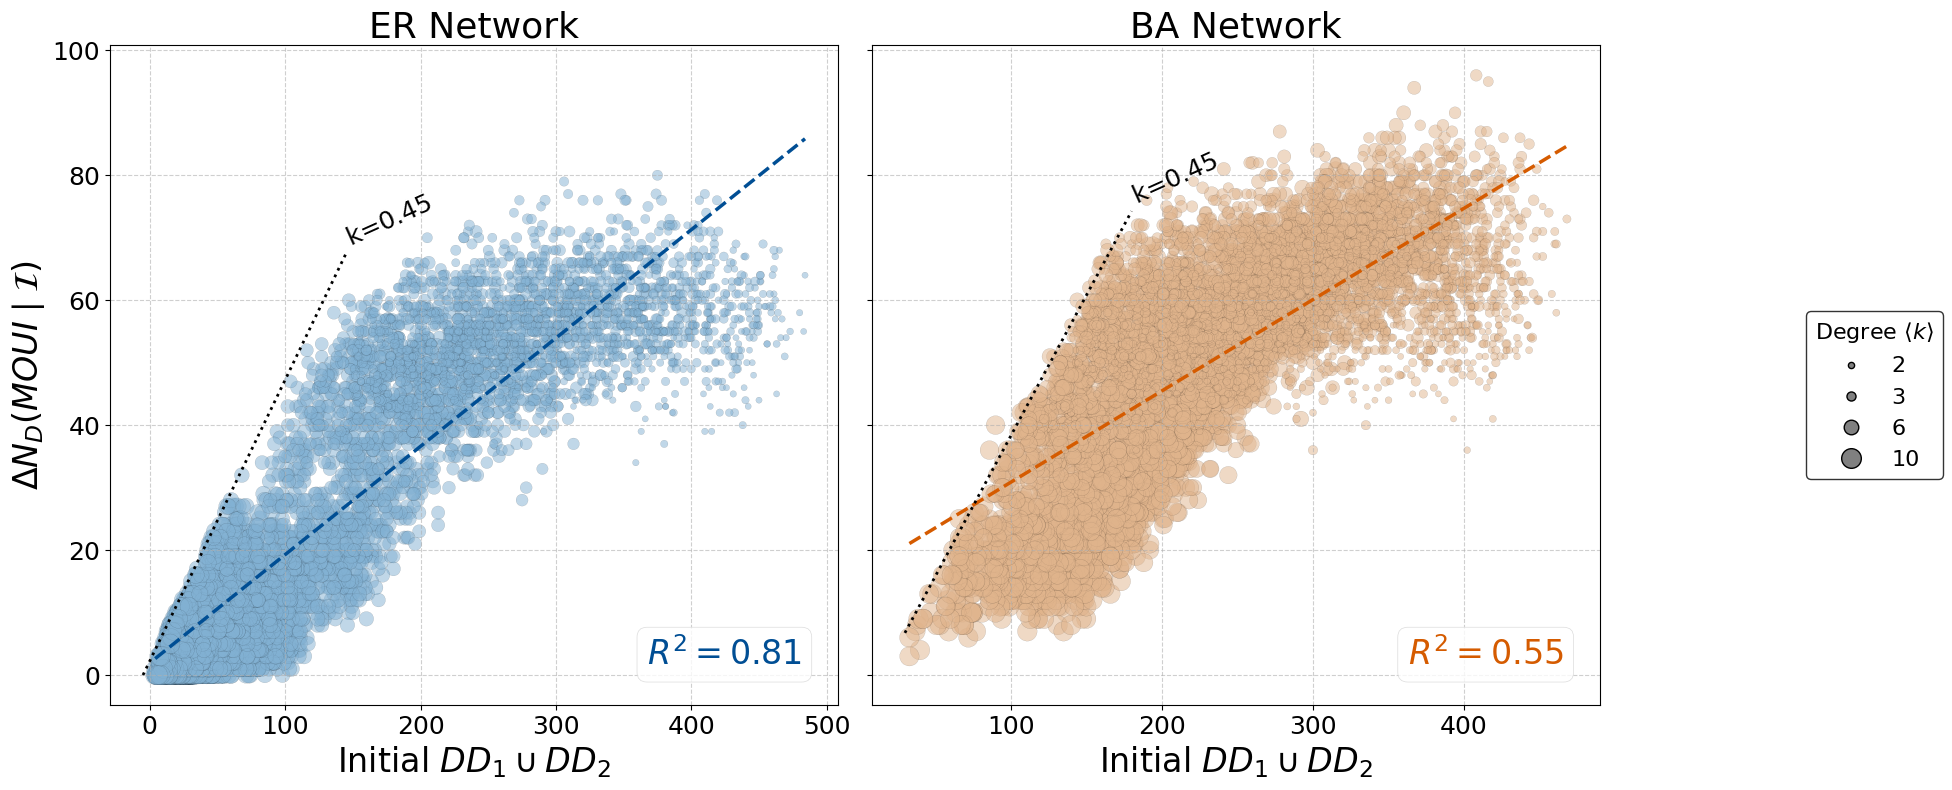

Scatter plot with subplots and manually controlled upper bound line generated.


In [5]:
df = pd.read_csv(RESULT_PATH / "optimization_proportion.csv")

# 网络类型映射以供显示
network_type_mapping_scatter = {
    "ER+ER": "ER",
    "BA+BA": "BA"
}
df['network_type_display'] = df['network_type'].map(network_type_mapping_scatter)
df = df.dropna(subset=['network_type_display']) # 删除映射后可能产生的空值行

# 计算相关指标
df['Total_Initial_Diff_MDS'] = df['Diff_MDS_1'] + df['Diff_MDS_2']
df['Nodes_Optimized_by_MOUI'] = df['UMDS_0'] - df['UMDS_ILP']

# --- 新增：手动设置上界线的斜率和长度 ---
# 您可以手动调整这个值来改变上界线
upper_bound_slope = 0.45
# 您可以手动设置上界线在 x 轴的终点
upper_bound_x_end = 150 # 调整此值以改变线的长度

# --- 创建包含子图的绘图 ---
fig_scatter, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# 为网络类型定义一致的颜色
palette_scatter = {
    "ER": COLOR['1'],
    "BA": COLOR['2']
}
line_palette_scatter = {
    "ER": COLOR['blue'],
    "BA": COLOR['orange']
}

# 定义图例中期望的 <k> 值
legend_k_values = [2, 3, 6, 10]
# 散点图中使用的大小范围
s_min, s_max = (20, 200)

# 准备两个子图的数据
er_data = df[df['network_type_display'] == 'ER']
ba_data = df[df['network_type_display'] == 'BA']
plot_configs = [
    {'ax': axes[0], 'data': er_data, 'title': 'ER Network', 'net_type': 'ER'},
    {'ax': axes[1], 'data': ba_data, 'title': 'BA Network', 'net_type': 'BA'}
]

# --- 循环生成子图 ---
for config in plot_configs:
    ax = config['ax']
    data = config['data']
    net_type = config['net_type']
    
    if data.empty:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center')
        ax.set_title(config['title'], fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
        continue

    # 绘制散点图
    sns.scatterplot(
        data=data,
        x='Total_Initial_Diff_MDS',
        y='Nodes_Optimized_by_MOUI',
        color=palette_scatter[net_type],
        size='<k>',
        sizes=(s_min, s_max),
        alpha=0.5,
        edgecolor='black',
        linewidth=0.1,
        ax=ax,
        legend=False
    )

    # --- 趋势线与注释 ---
    plot_data_scatter = data[['Total_Initial_Diff_MDS', 'Nodes_Optimized_by_MOUI']].dropna()
    bbox_style = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='lightgray', linewidth=0.5)

    if len(plot_data_scatter) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(
            plot_data_scatter['Total_Initial_Diff_MDS'], plot_data_scatter['Nodes_Optimized_by_MOUI']
        )
        print(f"Slope: {round(slope, 2)}, Intercept: {round(intercept, 2)}, R-value: {round(r_value, 2)}, P-value: {round(p_value, 2)}, Std-error: {round(std_err, 2)}")
        x_trend = np.array([plot_data_scatter['Total_Initial_Diff_MDS'].min(), plot_data_scatter['Total_Initial_Diff_MDS'].max()])
        if len(x_trend) > 1 and x_trend[0] < x_trend[1]:
            y_trend = intercept + slope * x_trend
            ax.plot(x_trend, y_trend, color=line_palette_scatter[net_type], linestyle='--', linewidth=2.5)
            ax.text(0.95, 0.05, f'$R^2={r_value**2:.2f}$',
                    transform=ax.transAxes,
                    color=line_palette_scatter[net_type], fontsize=AXIS_LABEL_FONTSIZE, ha='right', va='bottom', fontweight=FONT_WEIGHT,
                    bbox=bbox_style)

    # --- 更新：使用手动设置的终点绘制上界线 ---
    if not data.empty:
        # 使用手动设置的 x 轴终点
        x_bound = np.array([-5 if net_type == 'ER' else 30, upper_bound_x_end + (-5 if net_type == 'ER' else 30)])
        y_bound = upper_bound_slope * (x_bound - (-5 if net_type == 'ER' else 15))
        # 绘制黑色虚线
        ax.plot(x_bound, y_bound, color='black', linestyle=':', linewidth=2)
        # 计算旋转角度以匹配斜线
        angle = np.degrees(np.arctan(upper_bound_slope))
        # 在斜线末端添加文本
        ax.text(x_bound[1], y_bound[1], f' k={upper_bound_slope}', 
                fontsize=AXIS_TICK_FONTSIZE, 
                fontweight=FONT_WEIGHT, 
                color='black',
                ha='left',      # 水平对齐到文本左侧
                va='bottom',    # 垂直对齐到文本底部
                rotation=angle, # 旋转文本
                rotation_mode='anchor')


    # --- 坐标轴标签、标题、刻度 ---
    ax.set_xlabel(r'Initial $DD_1 \cup DD_2$', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
    ax.set_title(config['title'], fontsize=AXIS_LABEL_FONTSIZE + 2, fontweight=FONT_WEIGHT)
    ax.tick_params(axis='both', which='major', labelsize=AXIS_TICK_FONTSIZE)
    for ticklabel in ax.get_xticklabels() + ax.get_yticklabels():
        ticklabel.set_fontweight(FONT_WEIGHT)
    ax.grid(True, linestyle='--', alpha=0.6)


# --- 共享的 Y 轴标签 ---
axes[0].set_ylabel(r'$\Delta N_D(MOUI \mid \mathcal{I})$', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)


# --- 为整个 Figure 创建并放置一个统一的图例 ---
k_min, k_max = df['<k>'].min(), df['<k>'].max()
custom_handles = []
for k_val in legend_k_values:
    if (k_max - k_min) > 0:
        normalized_k = (k_val - k_min) / (k_max - k_min)
    else:
        normalized_k = 0.5
    normalized_k = max(0, min(1, normalized_k))
    marker_area = s_min + normalized_k * (s_max - s_min)
    custom_handles.append(Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor='gray',
                                 markeredgecolor='black',
                                 markersize=np.sqrt(marker_area),
                                 label=str(k_val)))

leg = fig_scatter.legend(handles=custom_handles,
                         title=r'Degree $\langle k \rangle$',
                         title_fontsize=LEGEND_FONTSIZE,
                         fontsize=LEGEND_FONTSIZE,
                         loc='center left',
                         bbox_to_anchor=(1, 0.5),
                         frameon=True, shadow=False, edgecolor='black')

for text in leg.get_texts():
    text.set_fontweight(FONT_WEIGHT)
if leg.get_title():
    leg.get_title().set_fontweight(FONT_WEIGHT)
    leg.get_title().set_fontsize(LEGEND_FONTSIZE)


# --- 最终调整并保存 ---
plt.tight_layout(rect=[0, 0, 0.9, 1])
figure_save_path_scatter = FIGURE_PATH / "fig.3.initial_diff_vs_optimized_nodes_subplots_with_bound.svg"
fig_scatter.savefig(figure_save_path_scatter, dpi=DPI, bbox_inches='tight')
print(f"Saved scatter plot to {figure_save_path_scatter}")

plt.show()
plt.close(fig_scatter)

print("Scatter plot with subplots and manually controlled upper bound line generated.")

# Result Figure 4

In [107]:
df = pd.read_csv(RESULT_PATH / "real_networks.csv")
df['<k>'].max(), df['<k>'].min()
df['Total_Initial_Diff_MDS'] = df['Diff_MDS_1'] + df['Diff_MDS_2']
df['Nodes_Optimized_by_MOUI'] = df['UMDS_0'] - df['UMDS_2']
df_plot = df[(df['Total_Initial_Diff_MDS'] > 0) & (df['Nodes_Optimized_by_MOUI'] > 0) & (df['<k>'] > 0)].copy()
df_plot

,network_name,layer_name_1,layer_name_2,N,N_1,N_2,E_1,E_2,<k>,<k_1>,...,Diff_MDS_1,Diff_MDS_2,UMDS_0,UMDS_1,UMDS_2,average_depth,time_1,time_2,Total_Initial_Diff_MDS,Nodes_Optimized_by_MOUI
0,Arabidopsis,direct_interaction,physical_association,6903,5493,2859,13857,4411,5.292771,5.045330,...,262,2033,6605,6577.0,6453,1.131579,4.730105,0.386726,2295,152
1,Celegans,direct_interaction,physical_association,3191,3126,239,5557,313,3.679097,3.555342,...,68,952,3149,3134.0,3114,1.085714,1.619151,0.029055,1020,35
2,Drosophila,direct_interaction,physical_association,8060,7356,2851,24094,12986,9.200993,6.550843,...,960,2876,7383,7352.0,7000,1.148825,6.770002,2.508040,3836,383
3,HumanHIV1,direct_interaction,physical_association,994,758,380,869,434,2.621730,2.292876,...,9,10,986,984.0,977,1.222222,0.285606,0.001515,19,9
4,SacchPomb,direct_interaction,physical_association,2622,971,2402,1686,7502,7.008391,3.472709,...,371,270,2364,2350.0,2267,1.247423,1.638327,0.418828,641,97
5,Rattus,direct_interaction,physical_association,2593,2035,1017,3014,1093,3.167759,2.962162,...,248,356,2437,2431.0,2381,1.250000,1.284877,0.101111,604,56
6,CelegansConnectome,ElectrJ,MonoSyn,275,253,260,1031,1639,19.418182,8.150198,...,37,20,63,59.0,55,1.625000,0.258742,0.015741,57,8
7,YeastLandscape,positive_interactions,negative_interactions,4455,4422,4432,67243,124066,85.885073,30.412935,...,924,913,3670,3619.0,2757,1.015334,5.416103,4.883946,1837,913
8,Cannes,RT,MT,438513,340349,233735,496982,411338,4.142728,2.920426,...,38758,33359,421101,NaN,419243,1.037675,NaN,2115.729128,72117,1858
9,MLKing,RT,MT,327660,288738,79070,291318,87144,2.310090,2.017871,...,11967,27705,321975,NaN,321726,1.016064,NaN,392.646861,39672,249


In [102]:
NETWORK_TYPES = {
    "Genetic & Neuronal": [
        "Arabidopsis",
        "Celegans",
        "Drosophila",
        "HumanHIV1",
        "SacchPomb",
        "Rattus",
        "YeastLandscape",
        "CelegansConnectome",
    ],
    "Social": [
        "Cannes",
        "GravitationalWaves",
        "MLKing",
        "MoscowAthletics",
        "NBAFinals",
        "NYClimate",
        "Sanremo",
        "UCLFinal",
    ],
    "Human Relationship": [
        "KrackhardtHighTech-f&a",
        "KrackhardtHighTech-f&r",
        "LazegaLawFirm-f&a",
        "LazegaLawFirm-f&c",
        "PhysiciansInnovation-f&a",
        "PhysiciansInnovation-f&d",
    ],
}

Slope: 0.72, Intercept: -0.42, R-value: 0.93, P-value: 0.0, Std-error: 0.07
已将log-log散点图保存到 ../assets/result/figure/fig.4.initial_diff_vs_optimized_nodes_log_log_scatter.svg


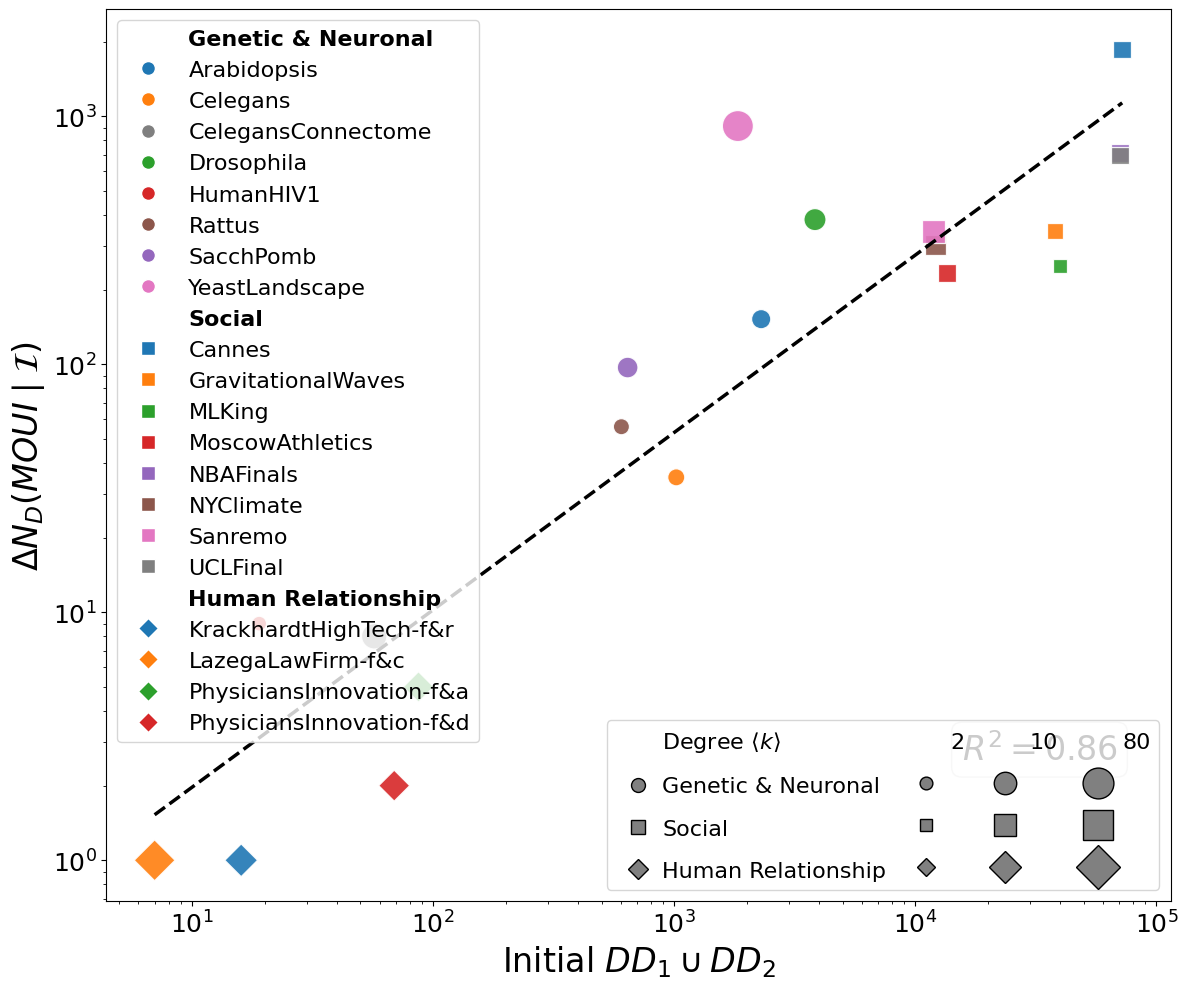

In [114]:
# --- 数据加载和准备 ---
df = pd.read_csv(RESULT_PATH / "real_networks.csv")

# 创建从网络名称到网络类型的反向映射
name_to_type = {name: type for type, names in NETWORK_TYPES.items() for name in names}
df['network_type'] = df['network_name'].map(name_to_type)

# 计算相关指标
df['Total_Initial_Diff_MDS'] = df['Diff_MDS_1'] + df['Diff_MDS_2']
df['Nodes_Optimized_by_MOUI'] = df['UMDS_0'] - df['UMDS_2']

# 筛选用于绘图的数据
df_plot = df[(df['Total_Initial_Diff_MDS'] > 0) & (df['Nodes_Optimized_by_MOUI'] > 0) & (df['<k>'] > 0)].copy()

# --- 绘图配置 ---

# 为每种网络类型定义标记形状
network_type_markers = {
    "Genetic & Neuronal": "o",          # 圆形
    "Social": "s",       # 方形
    "Human Relationship": "D",    # 菱形
}

# 为每个唯一的网络名称定义颜色
all_colors = list(sns.color_palette("tab10").as_hex())
palette_scatter = {}
for net_type in NETWORK_TYPES:
    color_index = 0
    unique_networks = [name for name in NETWORK_TYPES[net_type] if name in df_plot['network_name'].unique()]
    for net_name in unique_networks:
        palette_scatter[net_name] = all_colors[color_index]
        color_index = (color_index + 1) % len(all_colors)

# 定义标记的大小范围
s_min, s_max = (100, 500)

# --- 创建图表和坐标轴 ---
fig_scatter, ax_scatter = plt.subplots(figsize=(12, 10))

# --- 散点图 ---
scatter_plot = sns.scatterplot(
    data=df_plot,
    x='Total_Initial_Diff_MDS',
    y='Nodes_Optimized_by_MOUI',
    hue='network_name',
    style='network_type',
    markers=network_type_markers,
    palette=palette_scatter,
    size='<k>',
    sizes=(s_min, s_max),
    size_norm=mpl.colors.LogNorm(vmin=df_plot['<k>'].min(), vmax=df_plot['<k>'].max()),
    alpha=0.9,
    ax=ax_scatter,
    legend=False # 直接禁用默认图例
)

# --- 坐标轴和缩放 ---
ax_scatter.set_xscale('log')
ax_scatter.set_yscale('log')
ax_scatter.set_xlabel(r'Initial $DD_1 \cup DD_2$', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
ax_scatter.set_ylabel(r'$\Delta N_D(MOUI \mid \mathcal{I})$', fontsize=AXIS_LABEL_FONTSIZE, fontweight=FONT_WEIGHT)
ax_scatter.tick_params(axis='both', which='major', labelsize=AXIS_TICK_FONTSIZE)
for ticklabel in ax_scatter.get_xticklabels() + ax_scatter.get_yticklabels():
    ticklabel.set_fontweight(FONT_WEIGHT)

# --- 趋势线和 R² 标注 ---
log_x = np.log10(df_plot['Total_Initial_Diff_MDS'])
log_y = np.log10(df_plot['Nodes_Optimized_by_MOUI'])
if len(log_x) > 1:
    slope_all, intercept_all, r_value_all, p_value_all, std_err_all = linregress(log_x, log_y)
    print(f"Slope: {round(slope_all, 2)}, Intercept: {round(intercept_all, 2)}, R-value: {round(r_value_all, 2)}, P-value: {round(p_value_all, 2)}, Std-error: {round(std_err_all, 2)}")
    x_min_log, x_max_log = log_x.min(), log_x.max()
    x_trend_log = np.array([x_min_log, x_max_log])
    y_trend_log = intercept_all + slope_all * x_trend_log
    x_trend_linear = 10**x_trend_log
    y_trend_linear = 10**y_trend_log
    ax_scatter.plot(x_trend_linear, y_trend_linear, color='black', linestyle='--', linewidth=2.5)
    
    # --- 新增: 在图上标注 R² 值 ---
    bbox_style = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='lightgray')
    ax_scatter.text(0.95, 0.15, f'$R^2={r_value_all**2:.2f}$',
                  transform=ax_scatter.transAxes,
                  color='black', fontsize=AXIS_LABEL_FONTSIZE, ha='right', va='bottom', fontweight=FONT_WEIGHT,
                  bbox=bbox_style)


# --- 图例 ---

# 1. 为网络名称（颜色）和类型（形状）创建带子标题的自定义图例
hue_handles = []
plotted_networks = df_plot['network_name'].unique()

# 按照 NETWORK_TYPES 的顺序构建图例
for net_type, net_list in NETWORK_TYPES.items():
    networks_in_type_to_plot = [name for name in net_list if name in plotted_networks]
    if not networks_in_type_to_plot:
        continue

    # 添加子标题的伪句柄
    hue_handles.append(Line2D([0], [0], linestyle='none', label=net_type, color='none'))

    # 为该类型下的每个网络添加入口
    for net_name in sorted(networks_in_type_to_plot):
        color = palette_scatter.get(net_name)
        marker = network_type_markers.get(net_type, 'o')
        if color:
            # 添加带缩进的真实句柄
            hue_handles.append(Line2D([0], [0], marker=marker, color='w', label=f'{net_name}',
                                      markerfacecolor=color, markersize=10, linestyle='None'))

# 创建网络图例
hue_legend = ax_scatter.legend(
    handles=hue_handles,
    fontsize=LEGEND_FONTSIZE,
    loc='upper left',
    frameon=True
)

for handle, text in zip(hue_legend.legend_handles, hue_legend.get_texts()):
    if text.get_text() in [net_type for net_type in NETWORK_TYPES.keys()]:
        text.set_x(-0.5)
        text.set_fontweight("bold")
        handle.set_visible(False)

ax_scatter.add_artist(hue_legend)

# 2. 为尺寸(<k>)创建自定义图例
legend_k_values = [2, 10, 80]
k_min, k_max = df_plot['<k>'].min(), df_plot['<k>'].max()
norm = mpl.colors.LogNorm(vmin=k_min, vmax=k_max)
size_handles = []
# 添加一个空的伪句柄，用于显示标题
size_handles.append(Line2D([], [], color='none', label=r'Degree $\langle k \rangle$'))
# 为每个网络类型（形状）添加一个空的伪句柄作为列标题
for net_type in network_type_markers.keys():
    size_handles.append(Line2D([], [], marker=network_type_markers[net_type], color='w', markerfacecolor='gray', markeredgecolor='black', label=net_type, linestyle='None', markersize=10))

# 为每个 k 值创建一行图例条目
for k_val in legend_k_values:
    # 添加 k 值的标签
    size_handles.append(Line2D([], [], color='none', label=f'{int(k_val)}'))
    # 为每个网络类型（形状）创建对应的标记
    for net_type, marker in network_type_markers.items():
        normalized_k = norm(k_val)
        marker_area = s_min + normalized_k * (s_max - s_min)
        size_handles.append(Line2D([0], [0], marker=marker, color='w', markerfacecolor='gray', markeredgecolor='black',
                                   markersize=np.sqrt(marker_area), label='', linestyle='None'))

# 创建组合图例
num_cols = len(network_type_markers) + 1
size_leg = ax_scatter.legend(handles=size_handles, 
                             loc='lower right', 
                             frameon=True, 
                             ncol=num_cols,
                             handletextpad=0.1, # 减少句柄和文本之间的填充
                             columnspacing=0.8, # 减少列之间的间距
                             labelspacing=1.0,  # 增加行之间的间距
                             fontsize=LEGEND_FONTSIZE)

# 手动设置图例标题和列标题的样式
title_text = size_leg.get_texts()[0]
title_text.set_fontweight(FONT_WEIGHT)
title_text.set_fontsize(LEGEND_FONTSIZE)
# 将标题的虚拟句柄设为不可见
size_leg.legend_handles[0].set_visible(False)

# --- 最后调整并保存 ---
plt.tight_layout()
figure_save_path_scatter = FIGURE_PATH / "fig.4.initial_diff_vs_optimized_nodes_log_log_scatter.svg"
fig_scatter.savefig(figure_save_path_scatter, dpi=DPI, bbox_inches='tight')
print(f"已将log-log散点图保存到 {figure_save_path_scatter}")

plt.show()
plt.close(fig_scatter)